<a href="https://colab.research.google.com/github/gonzalezcortes/cryptocurrencies_covid/blob/main/Unified_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the code for our research that aims to predict the price of Bitcoin and Ethereum during the novel coronavirus (COVID-19) pandemic.

## Libreries

In [ ]:
%%capture
!pip install shap

In [ ]:
#Varias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
import warnings
import itertools
import random

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
#Regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb

In [ ]:
#ANN
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional

In [ ]:
%%capture
!pip install catboost
import catboost as cb

In [ ]:
#Google collab pro
from google.colab import drive
drive.mount('/content/drive')
ruta = '/content/drive/My Drive/Crypto_2021/Code/sample_data/'

Mounted at /content/drive


In [ ]:
name_assets = ['XRP', 'LTC', 'ETH', 'DOGE', 'PPC', 'BTS', 'XLM', 'NXT', 'MAID',
               'NMC', 'BTC', 'USDT', 'ADA', 'BNB','USDC']
trm = str('-USD.csv')

path_of_assets = [x+trm for x in name_assets]

## Preprocessing

In [ ]:
class Indicators:
    def norma(self, data, mini, maxi):
        z = (data-mini)/(maxi-mini)
        return z

    def desnorma(self, data, mini, maxi):
        d = (data*(maxi-mini))-mini
        return d

    def simple_ma(self, data, period):
        return data.rolling(period).mean()

    def rsi(self, data, period):
        ## ver np.where para acelerar
        change = data.diff()
        gain = pd.Series(list(map(lambda x: x if x > 0 else 0, change)))
        loss = pd.Series(list(map(lambda x: abs(x) if x < 0 else 0, change)))
        rs = gain.rolling(period).mean() / loss.rolling(period).mean()
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def stochastic_oscillator(self, data_close, data_low, data_high, period):
        so = 100*((data_close-data_low.rolling(period).min())/
                (data_close-data_high.rolling(period).max()-data_close-data_low.rolling(period).min()))
        return so

    def williams(self, data_close, data_low, data_high,period):
        r = ((data_high.rolling(period).max()-data_close)/
            (data_close-data_high.rolling(period).max()-data_close-data_low.rolling(period).min())) * -100
        return r

    def macd(self, data_close, p, q, r):
        #12,26,9
        signal_line = data_close.ewm(span=p, adjust=False).mean()-data_close.ewm(span=q, adjust=False).mean()
        return signal_line.ewm(span=r, adjust=False).mean()

    def obv(self, data_close, data_volumen):
        data_close = np.array(data_close)
        obv = np.zeros(data_close.shape)
        obv[0] = data_volumen[0]
        for i in range(1,data_close.shape[0]):
            if data_close[i] - data_close[i-1] > 0:
                obv[i] = obv[i-1] + data_volumen[i]
            elif data_close[i] - data_close[i-1] < 0:
                obv[i] = obv[i - 1] - data_volumen[i]
            else:
                obv[i] = obv[i-1]
        return obv

    def add_ma(self, data_set, name_data_set):
        data_set['ma_5 '+str(name_data_set)]  = self.simple_ma(data_set['Close'],5)
        data_set['ma_10 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 10)
        data_set['ma_20 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 20)
        data_set['ma_50 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 50)
        data_set['ma_100 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 100)
        data_set['ma_200 '+str(name_data_set)] = self.simple_ma(data_set['Close'], 200)
        return data_set

    def add_indicators(self, data_set, name_data_set):
        data_set['rsi '+str(name_data_set)] = self.rsi(data_set['Close'], 14)
        data_set['stoch '+str(name_data_set)] = self.stochastic_oscillator(data_set['Close'],data_set['Low'],data_set["High"],14)
        data_set['williams '+str(name_data_set)] = self.williams(data_set['Close'],data_set['Low'],data_set["High"],14)
        data_set['macd '+str(name_data_set)] = self.macd(data_set['Close'], 12, 26, 9)
        data_set['obv '+str(name_data_set)] = self.obv(data_set['Close'],data_set['Volume'])
        return data_set

    def add_lags_close(self, data_set, name_data_set):
        data_set['1-day_close '+str(name_data_set)] = data_set['Close'].shift(1)
        data_set['2-day_close '+str(name_data_set)] = data_set['Close'].shift(2)
        data_set['3-day_close '+str(name_data_set)] = data_set['Close'].shift(3)
        data_set['4-day_close '+str(name_data_set)] = data_set['Close'].shift(4)
        data_set['5-day_close '+str(name_data_set)] = data_set['Close'].shift(5)
        data_set['6-day_close '+str(name_data_set)] = data_set['Close'].shift(6)
        data_set['7-day_close '+str(name_data_set)] = data_set['Close'].shift(7)
        data_set['8-day_close '+str(name_data_set)] = data_set['Close'].shift(8)
        return data_set

    def volume_difference(self, data_set):
        #data_set['1-day_volume'] = (data_set['Volume'].shift(2)-data_set['Volume'].shift(1))/data_set['Volume'].shift(1)
        data_set['1-day_volume'] = data_set['Volume'].pct_change()
        return data_set

    def append_indicators(self, data_set, name_data_set):
        data_0 = data_set.drop(['Date'], axis=1)
        #data_0_n = self.norma(data_0, np.min(data_0), np.max(data_0))
        #data_1 = self.add_ma(data_0, name_data_set) ## Add MA
        
        data_1 = self.add_ma(data_0, name_data_set) ## Add MA
        data_1 = self.add_indicators(data_1, name_data_set) ## Add other indicators
        data_1 = self.add_lags_close(data_1, name_data_set) ## Add lags
        return data_1

    def MinMax(self, data_set):
        scaler = MinMaxScaler(feature_range=(-1, 1))
        return scaler.fit_transform(data_set)

In [ ]:
class DataSplit:

    def y_X_group_regression(self,data_set):
        y = data_set['Close'].shift(periods=-1)
        X = data_set
        y = pd.DataFrame(y)
        return y, X

    def y_X_group_classification(self,data_set):
        y = np.where(data_set['Close'].shift(-1) > data_set['Close'], 1, -1)
        X = data_set
        y = pd.DataFrame(y)
        return y, X

    def test_train_split(self,y,X,start_period,cut_period,end_period):
        y_train, X_train = y[start_period:cut_period], X[start_period:cut_period]
        y_test, X_test = y[cut_period:end_period], X[cut_period:end_period]
        return y_train, X_train, y_test , X_test

    def fill_nan_second(self, data_set, values):
        while data_set[str(values)].isnull().values.any() == True:
            data_set[str(values)] = data_set[str(values)].fillna(data_set[str(values)].shift(1))


## Show Results Class

In [ ]:
class ShowResults:
    def results_table(self, mses, r2s):
        print(tabulate([['31/12/2019 - 30/06/2020', round(mses[0],6), round(r2s[0],6)], 
                        ['01/07/2020 - 31/12/2020', round(mses[1],6), round(r2s[1],6)], 
                        ['01/01/2021 - 30/06/2021', round(mses[2],6), round(r2s[2],6)], 
                        ['-----------------------', '---------', '---------'] , 
                        ['Average', round(np.mean(mses),6), round(np.mean(r2s),6)]],  
                    headers=['Testing period','MSE', 'R2']))
        
    def plot_three(self, title, predicted_values, real_values):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(28, 10)
        fig.suptitle(title, fontsize = 24)
        axs = [ax1, ax2, ax3]
        subtitle = ['First testing period','Second testing period','Third testing period']
        for i in range(0,3):
            axs[i].plot([x for x in range(0, len(predicted_values[i]))], predicted_values[i], linestyle='dashed', label='Predicted values')
            axs[i].plot([x for x in range(0, len(predicted_values[i]))], real_values[i],label='Real values')
            axs[i].set_title(subtitle[i], fontsize = 18)
            axs[i].legend(["Predicted values", "Real values"])
            axs[i].set_xlabel("Days", fontsize = 14)
            axs[i].set_ylabel("Price (Scaled data)", fontsize = 14)
    
    def show_params(self, models):
        print(tabulate([["Model first period", models[0].get_params], 
                        ["Model second period", models[1].get_params], 
                        ["Model thrid period", models[2].get_params]],  
                    headers=['','Parameters']))

## Training algorithms

### Regression algorithms

In [ ]:
class RegressionAlgorithms:
    def __init__(self):
        warnings.filterwarnings("ignore")

    def DTR(self,y_train, X_train, iter):
        model = DecisionTreeRegressor()
        parameters={"splitter":["best","random"], 
                    "max_depth" : [None], 
                    "max_features" : [None], 
                    "min_samples_leaf":[x for x in range(1,100)],
                    "min_weight_fraction_leaf":[0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                    "max_leaf_nodes":[None],
                    "random_state": [0],
                    "n_jobs" : [-1]}

        tuning_model_search = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = iter,  n_jobs=-1, 
                                                 scoring='neg_mean_squared_error',cv=None, verbose=0, return_train_score=True, random_state = 0)

        dt = tuning_model_search.fit(X_train, y_train).best_params_
        tunned_model = DecisionTreeRegressor(**dt) ## Modification to be read with SHAP
        tunned_model.fit(X_train, y_train)
        return tunned_model

    def KNR(self,y_train, X_train, iter):
        model = KNeighborsRegressor()
        parameters={"n_neighbors" : [i for i in range(2,20)],
                    "weights" : ['uniform', 'distance'], 
                    "algorithm" : ['auto'], 
                    "leaf_size" : [j for j in range(2,50)], 
                    "p" : [k for k in range(1,100)], 
                    "metric" : ['minkowski'], 
                    "metric_params" : [None], 
                    "n_jobs" : [-1]}
        tuning_model_search=RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = iter,  n_jobs=-1, scoring='neg_mean_squared_error',
                                               cv=None,verbose=0,random_state = 0)

        dt = tuning_model_search.fit(X_train, y_train).best_params_
        tunned_model = KNeighborsRegressor(**dt) ## Modification to be read with SHAP
        tunned_model.fit(X_train, y_train)
        return tunned_model

    def RFR(self,y_train, X_train, iter):
        model = RandomForestRegressor()
        
        parameters={'n_estimators':[i for i in range(10,200,10)],  
                    'max_depth':[None], 'min_samples_split':[j for j in range(1,10,1)],
                    'min_samples_leaf':[k for k in range(2,20,1)], 
                    'min_weight_fraction_leaf':[0.0], 'max_features':['auto'], 
                    'max_leaf_nodes':[None], 'min_impurity_decrease':[0.0], 
                    'bootstrap':[True], 'oob_score':[False], 'n_jobs':[-1],
                     'verbose':[0], 'warm_start':[False], 
                    'ccp_alpha':[0.0], 'max_samples':[None],"random_state": [0]
                    }

        tuning_model_search=RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = iter,  n_jobs=-1, 
                                               scoring='neg_mean_squared_error',cv=None,verbose=0,random_state = 0)

        dt = tuning_model_search.fit(X_train, y_train).best_params_
        
        tunned_model = RandomForestRegressor(**dt) ## Modification to be read with SHAP

        tunned_model.fit(X_train, y_train)
        return tunned_model

    def XGBR(self,y_train, X_train, iter):

        model = XGBRegressor(nthread=-1)
        
        # A parameter grid for XGBoost
        parameters = {
            'n_estimators':[100,200,300,400,500],
            'min_child_weight':[4,5,6], 
            'gamma':[i/10.0 for i in range(0,6)],  
            'subsample':[1],
            'colsample_bytree':[i/10.0 for i in range(6,11)], 
            'max_depth': [x for x in range(1,20,1)],
            'objective': ['reg:squarederror', 'reg:tweedie'],
            'booster': ['gbtree'],#'gbtree', 'gblinear'
            'eval_metric': ['rmse'],
            'eta': [i/10.0 for i in range(3,6)],
        }

        tuning_model_search = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = iter,  n_jobs=-1, 
                                                 scoring='neg_mean_squared_error', cv=None, verbose=0, random_state = 0)

        dt = tuning_model_search.fit(X_train, y_train).best_params_
        tunned_model = XGBRegressor(**dt) ## Modification to be read with SHAP
        
        tunned_model.fit(X_train, y_train)
        return tunned_model

    def SVR(self,y_train, X_train, iter):
        model = SVR()
        parameters = {'C': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9],
                      'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                      'tol':[1e-3,1e-4,1e-5],
                      'gamma': ['scale', 'auto'],
                      'epsilon': [0.01,0.1,0.2]}

        tuning_model_search=RandomizedSearchCV(estimator = model, param_distributions = parameters, 
                                               n_iter = iter,  n_jobs=-1, 
                                               scoring='neg_mean_squared_error',cv=None,verbose=0, random_state = 0)

        dt = tuning_model_search.fit(X_train, y_train).best_params_
        tunned_model = SVR(**dt) ## Modification to be read with SHAP
        tunned_model.fit(X_train, y_train)
        return tunned_model

    def MLPR(self, y_train, X_train, iter):
        model = MLPRegressor()
        parameters = {
            'hidden_layer_sizes':[x for x in range(80,200,10)],
            'activation':['logistic', 'tanh', 'relu'],
            'solver':['adam'],
            'alpha':[0.1, 0.01, 0.001, 0.0001, 0.00001],
            'learning_rate':['constant', 'adaptive'],
            'learning_rate_init':[0.1, 0.01, 0.001, 0.0001, 0.00001],
            'max_iter':[500],
            'random_state':[0],
            'verbose':[0],
            'momentum':[0.85, 0.90, 0.95]}

        tuning_model_search = RandomizedSearchCV(estimator = model,
                                                 param_distributions = parameters,
                                                 n_iter = iter, n_jobs=-1, 
                                                 scoring='neg_mean_squared_error',
                                                 cv=None, verbose=0, random_state = 0)

        dt = tuning_model_search.fit(X_train, y_train).best_params_
        tunned_model = MLPRegressor(**dt) ## Modification to be read with SHAP
        tunned_model.fit(X_train, y_train)
        return tunned_model

    def LGB(self, y_train, X_train, iter):
        model = lgb.LGBMRegressor()
        parameters = {
            'n_estimators' : [x for x in range(100,1000,100)],
            "num_leaves": [x for x in range(20,200,10)], 
            'learning_rate': [0.05, 0.1],
            'n_jobs' : [-1],
            'verbose': [0],
            'min_child_samples' : [10, 15, 20, 30]
        }
        tuning_model_search = RandomizedSearchCV(estimator = model, 
                                                 param_distributions = parameters, 
                                                 n_iter = iter, 
                                                 n_jobs=-1, 
                                                 scoring='neg_mean_squared_error', 
                                                 cv=None, verbose=0, random_state = 0)

        dt = tuning_model_search.fit(X_train, y_train).best_params_
        tunned_model = lgb.LGBMRegressor(**dt) ## Modification to be read with SHAP
        tunned_model.fit(X_train, y_train)
        return tunned_model

    def CAT(self, y_train, X_train, iter):
        model = cb.CatBoostRegressor()

        parameters = {'iterations': [100, 150, 200],
                'learning_rate': [0.01, 0.03, 0.05, 0.1],
                'depth': [2, 4, 6, 8],
                'l2_leaf_reg': [0.2, 0.5, 1, 3],
                'loss_function' : ['RMSE'],
                'n_jobs' : [-1],
                'silent': [True]}
        
        tuning_model_search = RandomizedSearchCV(estimator = model, 
                                                 param_distributions = parameters, 
                                                 n_iter = iter, 
                                                 n_jobs=-1, 
                                                 scoring='neg_mean_squared_error', 
                                                 cv=None, verbose=0, random_state = 0)
        
        dt = tuning_model_search.fit(X_train, y_train).best_params_
        tunned_model = cb.CatBoostRegressor(**dt) ## Modification to be read with SHAP
        tunned_model.fit(X_train, y_train)
        return tunned_model

### Neural networks keras

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
class NNAlgorithms:
    def __init__(self):
        np.random.seed(0)
        if tf.__version__ == "1.14.0":
            tf.set_random_seed(0)
        else:
            tf.random.set_seed(0)

        self.best_model = {'first_set':[], 'second_set':[], 'thrid_set':[]}
        self.lowest_error = {'first_set':[100], 'second_set':[100], 'thrid_set':[100]}
        self.real_values = {'first_set':[], 'second_set':[], 'thrid_set':[]}
        self.predicted_values = {'first_set':[], 'second_set':[], 'thrid_set':[]}
        self.r2s = {'first_set':[], 'second_set':[], 'thrid_set':[]}

    def condition_select(self,model,mse,y_test,y_test_pred,periods,r2):
        if mse < self.lowest_error[periods]:
            self.lowest_error[periods] = mse
            self.best_model[periods] = model
            self.real_values[periods] = y_test
            self.predicted_values[periods] = y_test_pred
            self.r2s[periods] = r2
        

    def lstm_simple(self, y_train, X_train, y_test, X_test, n_p, ep, periods):
        model = Sequential()
        model.add(LSTM(n_p, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        X_train_lstm = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
        X_test_lstm = X_test.reshape(X_test.shape[0],X_train.shape[1],1)

        model.fit(X_train_lstm,y_train, epochs=ep, verbose=0)
        y_test_pred = model.predict(X_test_lstm)

        mse = mean_squared_error(y_test,y_test_pred)
        r2 = r2_score(y_test,y_test_pred)
        return model, mse, y_test, y_test_pred, r2

    def lstm_stack(self, y_train, X_train, y_test, X_test, n_p, ep, periods):
        model = Sequential()
        model.add(LSTM(n_p[0], return_sequences=True,input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.2))

        model.add(LSTM(n_p[1], return_sequences=True))
        model.add(Dropout(0.2))

        model.add(LSTM(n_p[2]))
        model.add(Dropout(0.2))
        
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        X_train_lstm = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
        X_test_lstm = X_test.reshape(X_test.shape[0],X_train.shape[1],1)

        model.fit(X_train_lstm,y_train, epochs=ep, verbose=0)
        y_test_pred = model.predict(X_test_lstm)
        
        mse = mean_squared_error(y_test,y_test_pred)
        r2 = r2_score(y_test,y_test_pred)
        return model, mse, y_test, y_test_pred, r2

    def lstm_bi(self, y_train, X_train, y_test, X_test, n_p, ep, periods):

        model = Sequential()
        model.add(Bidirectional(LSTM(n_p, activation='tanh', input_shape=(X_train.shape[1], 1))))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        X_train_lstm = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
        X_test_lstm = X_test.reshape(X_test.shape[0],X_train.shape[1],1)

        model.fit(X_train_lstm,y_train, epochs=ep, verbose=0)
        y_test_pred = model.predict(X_test_lstm)

        mse = mean_squared_error(y_test,y_test_pred)
        r2 = r2_score(y_test,y_test_pred)
        return model, mse, y_test, y_test_pred, r2

    def search(self, y_train, X_train, y_test, X_test, periods, iter, choice):

        model_choice = {"lstm_bi":0,"lstm_simple":1,"lstm_stack":2}

        n_sizes = [x for x in range(25,250,5)]
        ep = [20,50,100,200]
        c = itertools.permutations(n_sizes, 3)

        cb_stack = [pair for pair in itertools.product(c,ep)]
        cb_lstm = [pair for pair in itertools.product(n_sizes, ep)]

        cb_stack_choice = random.sample(cb_stack, iter)
        cb_lstm_choice = random.sample(cb_lstm, iter)

        if model_choice[choice] == 2:
            for i in range(0,iter):
                print(periods," ",i+1)
                model, mse, y_test, y_test_pred, r2 = self.lstm_stack(y_train, X_train, y_test, X_test, cb_stack_choice[i][0], cb_stack_choice[i][1], periods)
                self.condition_select(model,mse,y_test,y_test_pred,periods,r2)
        elif model_choice[choice] == 1:
            for i in range(0,iter):
                print(periods," ",i+1)
                model, mse, y_test, y_test_pred, r2 = self.lstm_simple(y_train, X_train, y_test, X_test, cb_lstm_choice[i][0], cb_lstm_choice[i][1], periods)
                self.condition_select(model,mse,y_test,y_test_pred,periods,r2)
        else:
            for i in range(0,iter):
                print(periods," ",i+1)
                model, mse, y_test, y_test_pred, r2 = self.lstm_bi(y_train, X_train, y_test, X_test, cb_lstm_choice[i][0], cb_lstm_choice[i][1], periods)
                self.condition_select(model,mse,y_test,y_test_pred,periods,r2)
        return self.best_model[periods]
        

## Call classes

In [ ]:
TechInd = Indicators()
Split = DataSplit()
RAlgo = RegressionAlgorithms()
RNeuro = NNAlgorithms()
Show = ShowResults()

## Training

### Pipeline

In [ ]:
#training pipeline
def training_pipeline(currency, n_iterations, ml_model):
    currency_dict = {"ETH":2, "BTC":10}

    #######################################################
    index_date = pd.DataFrame({'Date': pd.read_csv(str(ruta)+'ETH-USD.csv')['Date']})
    name_assets_2 = ['bcom','cac','dax','spx','ukx','vix', 'ndx', 'xau']
    trm_2 = str('.csv')

    df_bcom = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[0] + trm_2), how = 'left', on = ['Date']) 
    df_cac = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[1] + trm_2), how = 'left', on = ['Date']) 
    df_dax = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[2] + trm_2), how = 'left', on = ['Date']) 

    df_spx = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[3] + trm_2), how = 'left', on = ['Date']) 
    df_ukx = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[4] + trm_2), how = 'left', on = ['Date']) 
    df_vix = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[5] + trm_2), how = 'left', on = ['Date'])

    df_ndx = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[6] + trm_2), how = 'left', on = ['Date'])
    df_xau = index_date.merge(pd.read_csv(str(ruta) + name_assets_2[7] + trm_2), how = 'left', on = ['Date'])

    tr = [df_bcom,df_cac,df_dax,df_spx,df_ukx,df_vix,df_ndx,df_xau]
    #######################################################

    yt_r, Xt_r = [],[]
    #First set of variables
    for asset in range(0,len(name_assets)):
        if asset == currency_dict[currency]:
            data_b_r = TechInd.append_indicators(pd.read_csv(str(ruta)+str(path_of_assets[asset])),name_assets[asset])

            y0, X0 = Split.y_X_group_regression(data_b_r)
            y0.rename(columns={'Close': 'Close target '+str(name_assets[asset])}, inplace=True)
            yt_r.append(y0)

        else:
            data_b_r = pd.read_csv(str(ruta)+str(path_of_assets[asset]))
            data_b_r = data_b_r.drop(['Date'], axis=1)
            X0 = data_b_r

        #Rename columns
        
        X0.rename(columns={'Open':'Open '+str(name_assets[asset]), 
                        'High':'High '+str(name_assets[asset]), 
                        'Low':'Low '+str(name_assets[asset]), 
                        'Close':'Close '+str(name_assets[asset]),
                        'Volume':'Volume '+str(name_assets[asset]),
                        'Adj Close':'Adj Close '+str(name_assets[asset])}, inplace=True)
        #yt_r.append(y0)
        Xt_r.append(X0)

    #Second set of variables
    for asset_2 in range(0,len(tr)):
        Split.fill_nan_second(tr[asset_2],'PX_LAST')
        tr[asset_2].rename(columns={'PX_LAST': 'Close '+str(name_assets_2[asset_2])}, inplace=True)
        
        if (asset_2 != 0 and asset_2 != 5 and asset_2 != 7):
            Split.fill_nan_second(tr[asset_2],'PX_VOLUME')
            tr[asset_2].rename(columns={'PX_VOLUME': 'Volume '+str(name_assets_2[asset_2])}, inplace=True)
        else:
            tr[asset_2] = tr[asset_2].drop(['PX_VOLUME'], axis=1)

        data_c_r = tr[asset_2].drop(['Date'], axis=1)
        #data_c_r = TechInd.norma(data_c_r, np.min(data_c_r), np.max(data_c_r))
        Xt_r.append(data_c_r)
    
    #######################################################
    y_concat_r, X_concat_r = pd.concat(yt_r, axis=1), pd.concat(Xt_r, axis=1)
    
    #######################################################
    ## 31/12/2019 - 1582 - ## 30/06/2020 - 1764
    ## 31/12/2020 - 1948 - ## 30/06/2021 - 2129

    training_set_index = {'first_set':[566, 1582, 1764], 
                          'second_set':[748, 1764, 1948], 
                          'thrid_set':[932, 1948, 2129]}
    
    models = []
    predicted_values = []
    real_values = []
    mses = []
    r2s = []

    ml_models = {"DTR": RAlgo.DTR, "KNR": RAlgo.KNR, "RFR": RAlgo.RFR, "XGBR": RAlgo.XGBR,
                 "MLPR": RAlgo.MLPR, "LGB": RAlgo.LGB, "CAT": RAlgo.CAT}
    
    for periods in training_set_index:
        #print(training_set_index[periods])
        #print(training_set_index[periods][0], training_set_index[periods][1], training_set_index[periods][2])
        
        y_train_r, X_train_r, y_test_r, X_test_r = Split.test_train_split(y_concat_r, X_concat_r, training_set_index[periods][0], training_set_index[periods][1], training_set_index[periods][2])
        
        #######################################################
        X_train_sc = TechInd.MinMax(X_train_r)
        y_train_sc = TechInd.MinMax(y_train_r)
        X_test_sc = TechInd.MinMax(X_test_r)
        y_test_sc = TechInd.MinMax(y_test_r)

        #######################################################
        if ml_model == "lstm_simple" or ml_model == "lstm_bi" or ml_model == "lstm_stack":
            RNeuro.search(y_train_sc, X_train_sc, y_test_sc, X_test_sc, periods, n_iterations, ml_model)

        #######################################################
        else:
            model_r = ml_models[ml_model](y_train_sc, X_train_sc, n_iterations)
        
            predicted_r = model_r.predict(X_test_sc)
        
            models.append(model_r)
            predicted_values.append(predicted_r)
            real_values.append(y_test_sc)
            mses.append(mean_squared_error(predicted_r, y_test_sc))
            r2s.append(r2_score(predicted_r, y_test_sc))
            
    return models, predicted_values, real_values, mses, r2s

### **Machine learning regressions**

#### Decision Tree Regressor (DTR)

##### ETH

In [ ]:
models_dtr_eth, predicted_values_dtr_eth, real_values_dtr_eth, mses_dtr_eth, r2s_dtr_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "DTR")

###### Results

In [ ]:
Show.results_table(mses_dtr_eth, r2s_dtr_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.039916   0.871534
01/07/2020 - 31/12/2020  0.01968    0.919393
01/01/2021 - 30/06/2021  0.014941   0.913743
-----------------------  ---------  ---------
Average                  0.024846   0.901557


###### Graphs

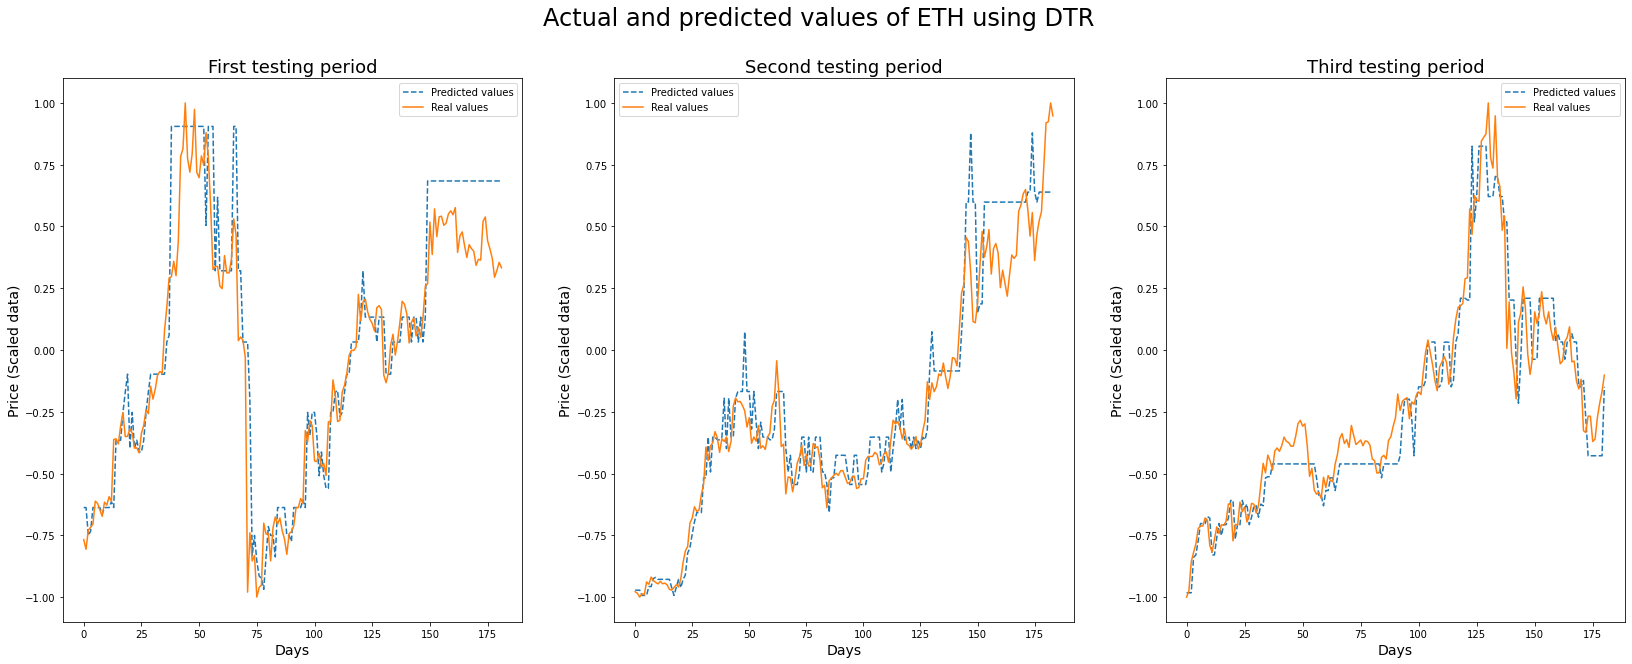

In [ ]:
Show.plot_three("Actual and predicted values of ETH using DTR", predicted_values_dtr_eth, real_values_dtr_eth)

###### Parameters

In [ ]:
Show.show_params(models_dtr_eth)

                     Parameters
-------------------  -----------------------------------------------------------------------------------------------------------------------
Model first period   <bound method BaseEstimator.get_params of DecisionTreeRegressor(min_samples_leaf=4, random_state=0, splitter='random')>
Model second period  <bound method BaseEstimator.get_params of DecisionTreeRegressor(min_samples_leaf=5, random_state=0, splitter='random')>
Model thrid period   <bound method BaseEstimator.get_params of DecisionTreeRegressor(min_samples_leaf=9, random_state=0, splitter='random')>


##### BTC

In [ ]:
models_dtr_btc, predicted_values_dtr_btc, real_values_dtr_btc, mses_dtr_btc, r2s_dtr_btc = training_pipeline(currency = "BTC", n_iterations = 100, ml_model = "DTR")

###### Results

In [ ]:
Show.results_table(mses_dtr_btc,r2s_dtr_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.022477   0.905668
01/07/2020 - 31/12/2020  0.044211   0.839114
01/01/2021 - 30/06/2021  0.117307   0.270624
-----------------------  ---------  ---------
Average                  0.061331   0.671802


###### Graphs

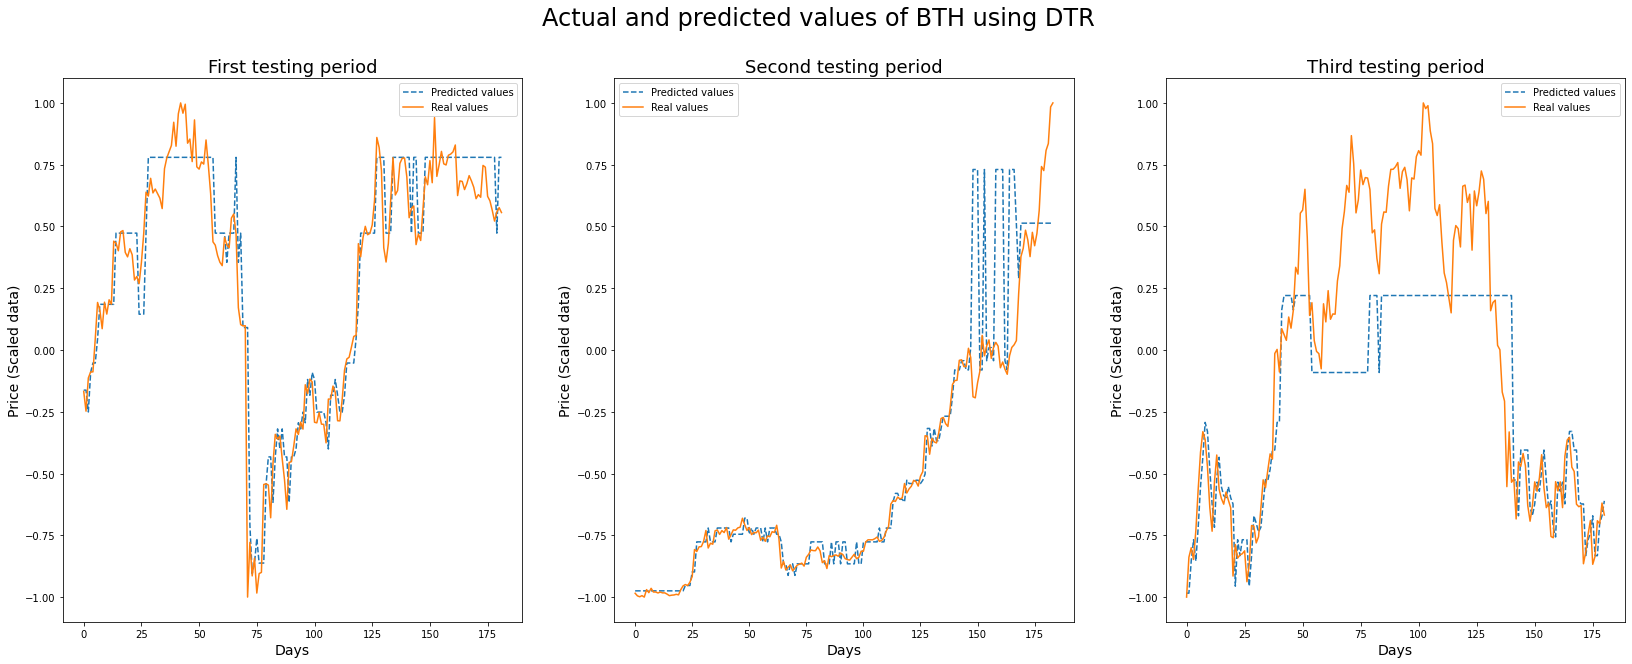

In [ ]:
Show.plot_three("Actual and predicted values of BTH using DTR", predicted_values_dtr_btc, real_values_dtr_btc)

###### Parameters

In [ ]:
Show.show_params(models_dtr_btc)

                     Parameters
-------------------  -----------------------------------------------------------------------------------------------------------------------
Model first period   <bound method BaseEstimator.get_params of DecisionTreeRegressor(min_samples_leaf=9, random_state=0, splitter='random')>
Model second period  <bound method BaseEstimator.get_params of DecisionTreeRegressor(min_samples_leaf=14, random_state=0)>
Model thrid period   <bound method BaseEstimator.get_params of DecisionTreeRegressor(min_samples_leaf=14, random_state=0)>


#### K-nearest Neighbors Regression (KNR)

##### ETH

In [ ]:
models_knr_eth, predicted_values_knr_eth, real_values_knr_eth, mses_knr_eth, r2s_knr_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "KNR")

###### Results

In [ ]:
Show.results_table(mses_knr_eth, r2s_knr_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.06037    0.797913
01/07/2020 - 31/12/2020  0.020451   0.916504
01/01/2021 - 30/06/2021  0.029823   0.832919
-----------------------  ---------  ---------
Average                  0.036881   0.849112


###### Graphs

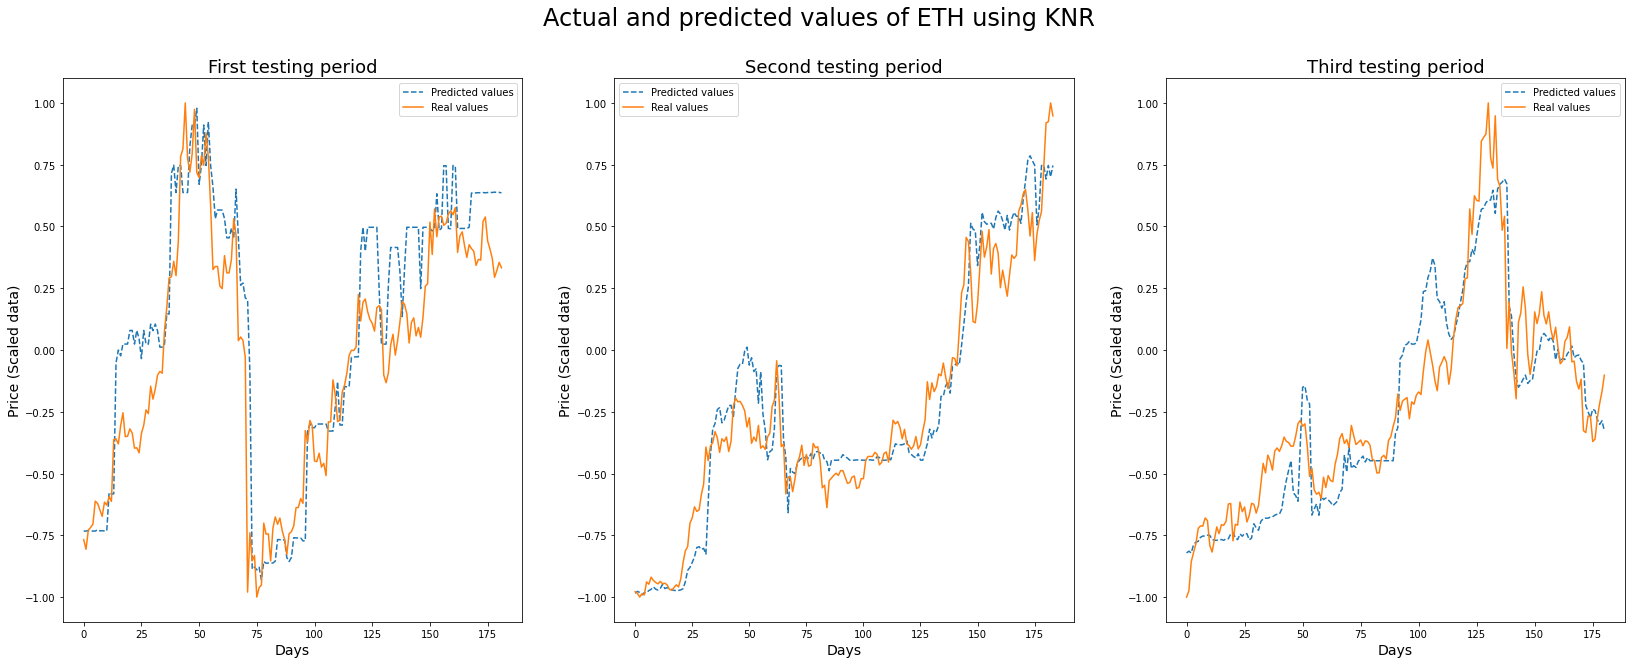

In [ ]:
Show.plot_three("Actual and predicted values of ETH using KNR", predicted_values_knr_eth, real_values_knr_eth)

###### Parameters

In [ ]:
Show.show_params(models_knr_eth)

                     Parameters
-------------------  ---------------------------------------------------------------------------------------------------------------------------
Model first period   <bound method BaseEstimator.get_params of KNeighborsRegressor(leaf_size=39, n_jobs=-1, n_neighbors=2, p=1,
                                         weights='distance')>
Model second period  <bound method BaseEstimator.get_params of KNeighborsRegressor(leaf_size=38, n_jobs=-1, n_neighbors=8, p=1)>
Model thrid period   <bound method BaseEstimator.get_params of KNeighborsRegressor(leaf_size=18, n_jobs=-1, n_neighbors=15, weights='distance')>


##### BTC

In [ ]:
models_knr_btc, predicted_values_knr_btc, real_values_knr_btc, mses_knr_btc, r2s_knr_btc = training_pipeline(currency = "BTC", n_iterations = 100, ml_model = "KNR")

###### Results

In [ ]:
Show.results_table(mses_knr_btc, r2s_knr_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.110964   0.109731
01/07/2020 - 31/12/2020  0.022159   0.858403
01/01/2021 - 30/06/2021  0.145628   0.254096
-----------------------  ---------  ---------
Average                  0.092917   0.40741


###### Graphs

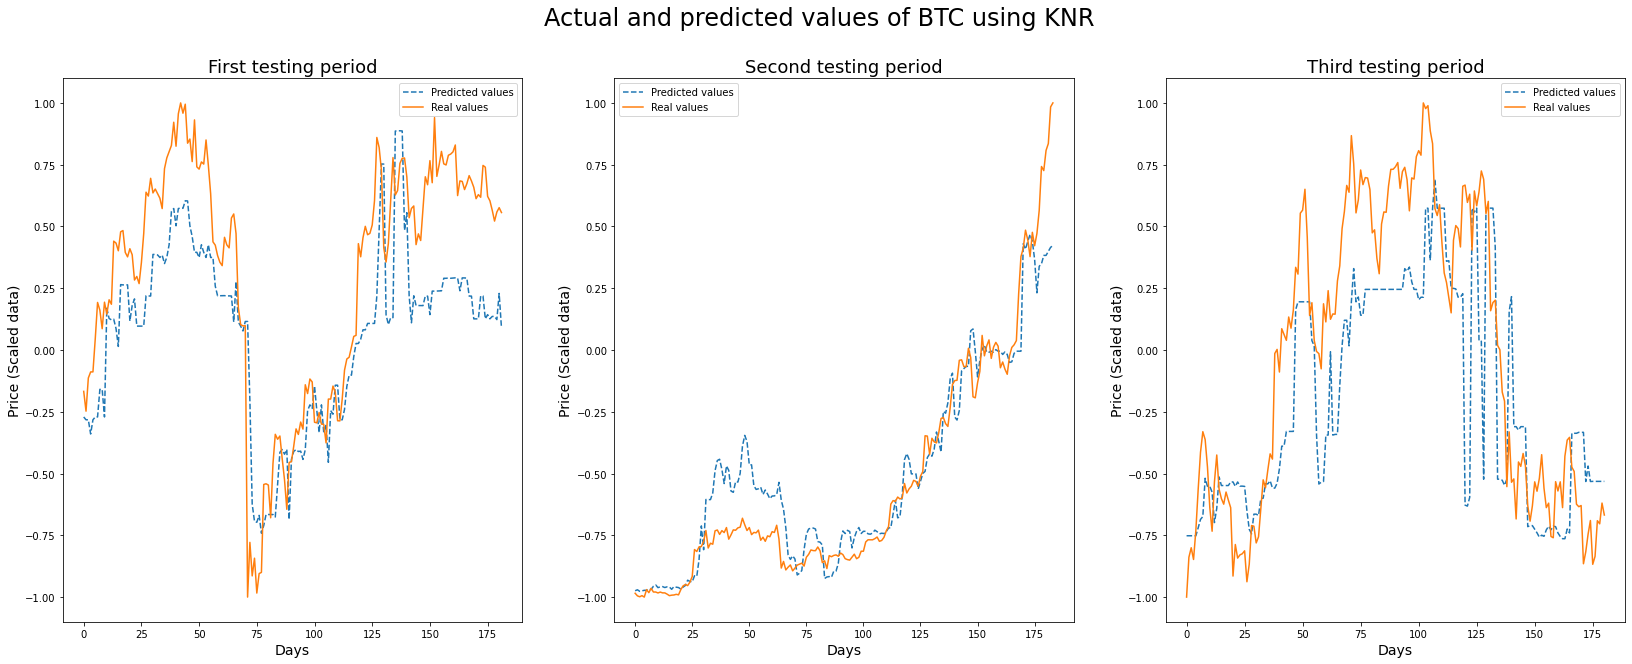

In [ ]:
Show.plot_three("Actual and predicted values of BTC using KNR", predicted_values_knr_btc, real_values_knr_btc)

###### Parameters

In [ ]:
Show.show_params(models_knr_btc)

                     Parameters
-------------------  ------------------------------------------------------------------------------------------------------------
Model first period   <bound method BaseEstimator.get_params of KNeighborsRegressor(leaf_size=39, n_jobs=-1, n_neighbors=2, p=1,
                                         weights='distance')>
Model second period  <bound method BaseEstimator.get_params of KNeighborsRegressor(leaf_size=32, n_jobs=-1, n_neighbors=10, p=1)>
Model thrid period   <bound method BaseEstimator.get_params of KNeighborsRegressor(leaf_size=39, n_jobs=-1, n_neighbors=2, p=1,
                                         weights='distance')>


#### Random Forest Regression (RFR)

##### ETH

In [ ]:
models_rfr_eth, predicted_values_rfr_eth, real_values_rfr_eth, mses_rfr_eth, r2s_rfr_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "RFR")

###### Results

In [ ]:
Show.results_table(mses_rfr_eth, r2s_rfr_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.025617   0.901494
01/07/2020 - 31/12/2020  0.013093   0.938078
01/01/2021 - 30/06/2021  0.009101   0.946618
-----------------------  ---------  ---------
Average                  0.015937   0.92873


###### Graphs

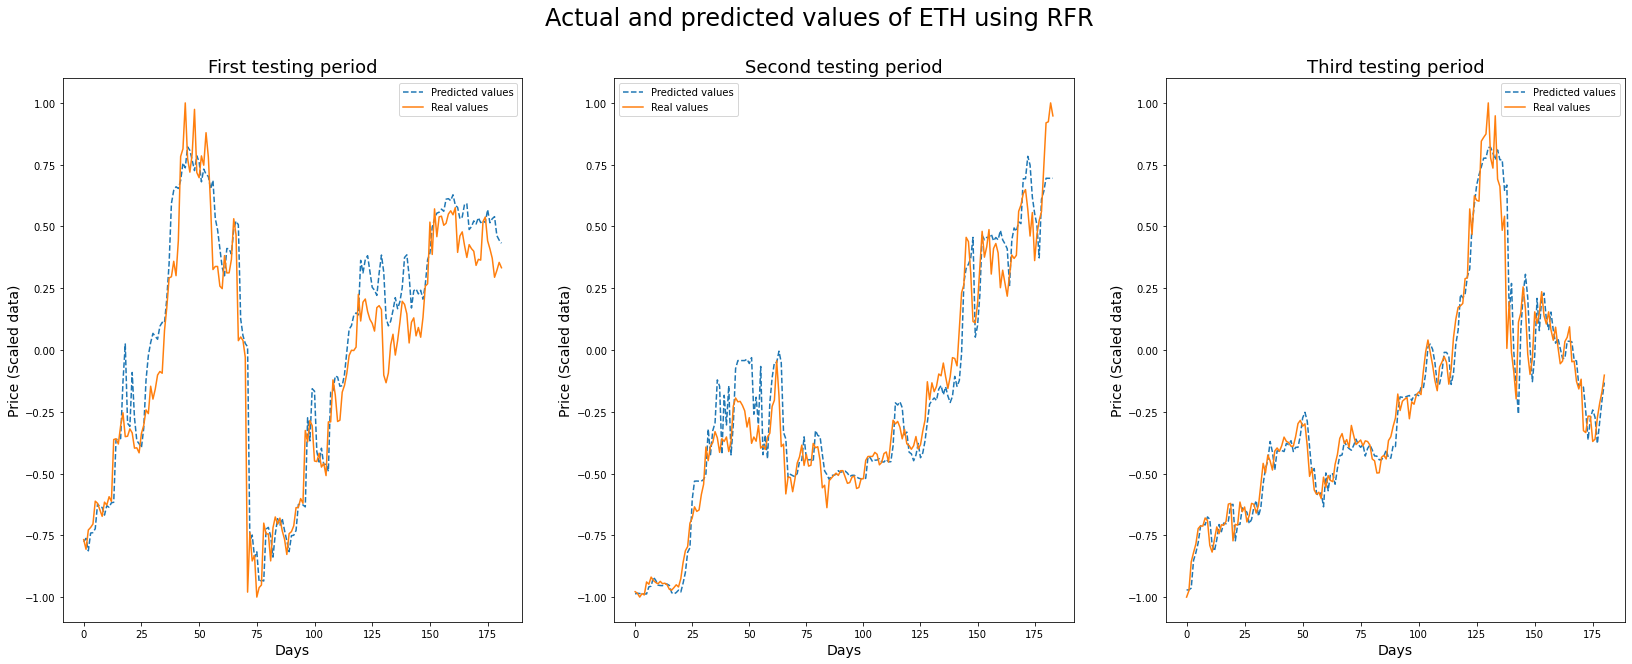

In [ ]:
Show.plot_three("Actual and predicted values of ETH using RFR", predicted_values_rfr_eth, real_values_rfr_eth)

###### Parameters

In [ ]:
Show.show_params(models_rfr_eth)

                     Parameters
-------------------  -------------------------------------------------------------------------------------------------------------------------
Model first period   <bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=2, n_estimators=40, random_state=0)>
Model second period  <bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=4, min_samples_split=5, n_estimators=10,
                                           random_state=0)>
Model thrid period   <bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=4, min_samples_split=5, n_estimators=10,
                                           random_state=0)>


##### BTC

In [ ]:
models_rfr_btc, predicted_values_rfr_btc, real_values_rfr_btc, mses_rfr_btc, r2s_rfr_btc = training_pipeline(currency = "BTC", n_iterations = 100, ml_model = "RFR")

###### Results

In [ ]:
Show.results_table(mses_rfr_btc, r2s_rfr_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.043714   0.726205
01/07/2020 - 31/12/2020  0.011374   0.950658
01/01/2021 - 30/06/2021  0.058414   0.724455
-----------------------  ---------  ---------
Average                  0.037834   0.800439


###### Graphs

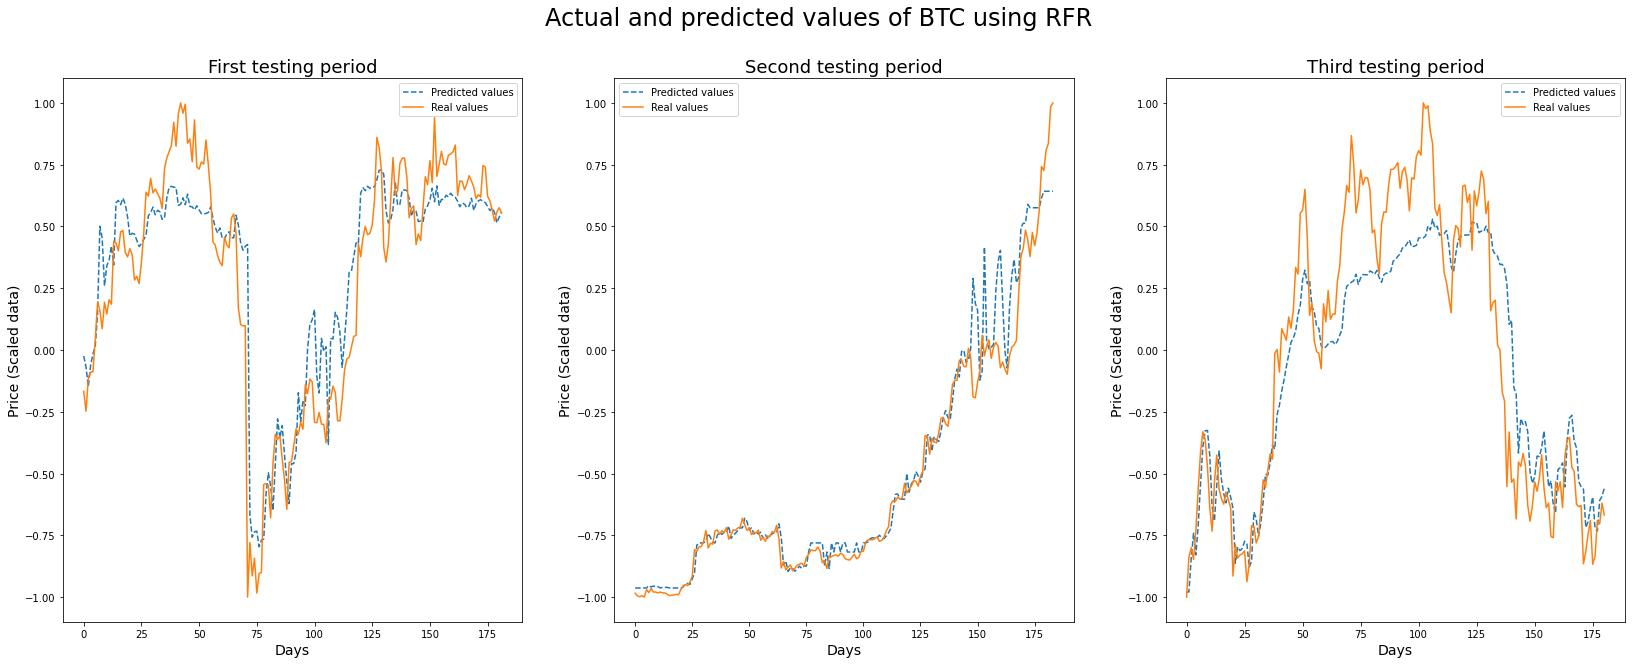

In [ ]:
Show.plot_three("Actual and predicted values of BTC using RFR", predicted_values_rfr_btc, real_values_rfr_btc)

###### Parameters

In [ ]:
Show.show_params(models_rfr_btc)

                     Parameters
-------------------  --------------------------------------------------------------------------------------------------------------------------
Model first period   <bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=2, n_estimators=120, random_state=0)>
Model second period  <bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=9, min_samples_split=7, n_estimators=10,
                                           random_state=0)>
Model thrid period   <bound method BaseEstimator.get_params of RandomForestRegressor(min_samples_leaf=9, min_samples_split=7, n_estimators=160,
                                           random_state=0)>


#### XGBoost (XGBR)


##### ETH

In [ ]:
models_XGBR_eth, predicted_values_XGBR_eth, real_values_XGBR_eth, mses_XGBR_eth, r2s_XGBR_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "XGBR")

###### Results

In [ ]:
Show.results_table(mses_XGBR_eth, r2s_XGBR_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.028661   0.888136
01/07/2020 - 31/12/2020  0.014827   0.929759
01/01/2021 - 30/06/2021  0.008415   0.949531
-----------------------  ---------  ---------
Average                  0.017301   0.922475


###### Graphs

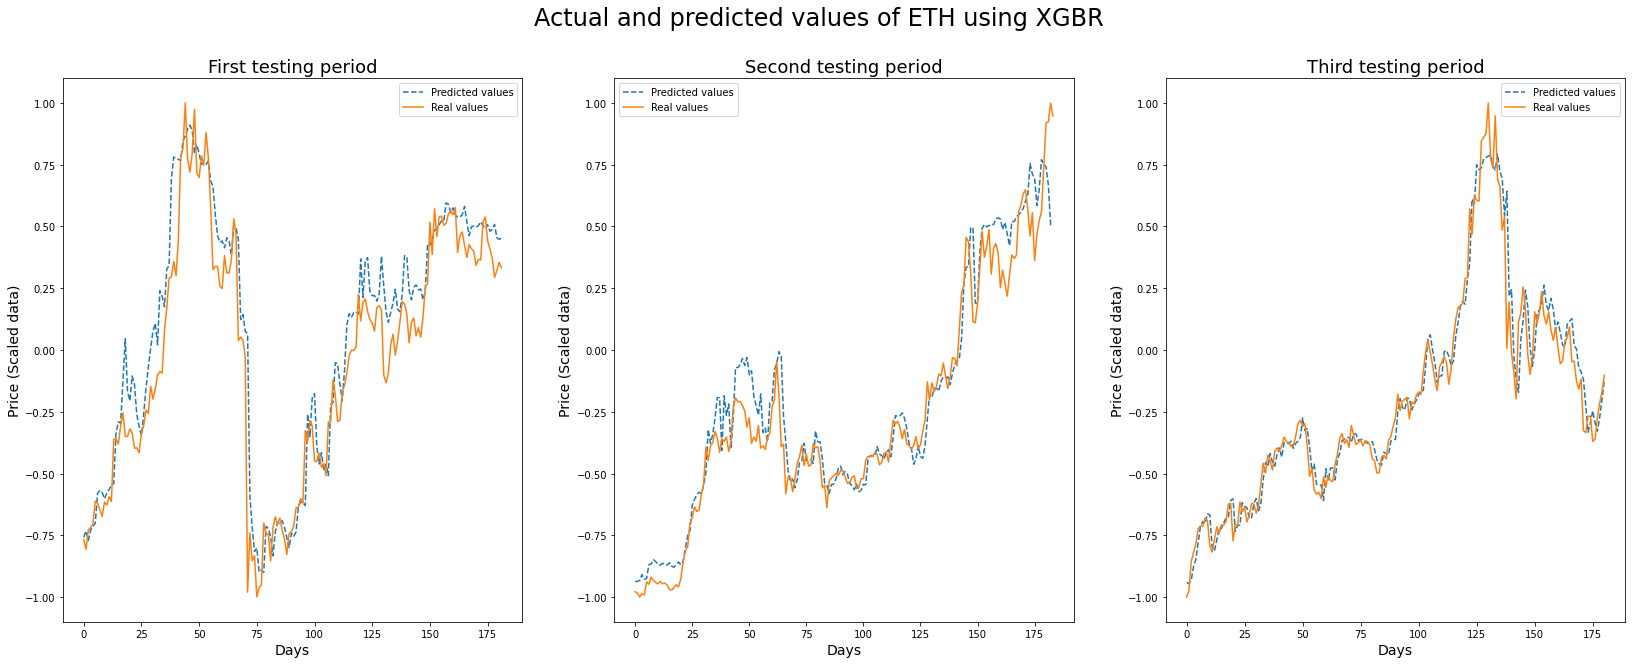

In [ ]:
Show.plot_three("Actual and predicted values of ETH using XGBR", predicted_values_XGBR_eth, real_values_XGBR_eth)

###### Parameters

In [ ]:
Show.show_params(models_XGBR_eth)

                     Parameters
-------------------  ---------------------------------------------------------------------------------------------------------------
Model first period   <bound method XGBModel.get_params of XGBRegressor(colsample_bytree=0.6, eta=0.4, eval_metric='rmse', gamma=0.0,
                                  max_depth=17, min_child_weight=5, n_estimators=500,
                                  objective='reg:squarederror')>
Model second period  <bound method XGBModel.get_params of XGBRegressor(colsample_bytree=0.8, eta=0.4, eval_metric='rmse', gamma=0.0,
                                  max_depth=8, min_child_weight=4, n_estimators=200,
                                  objective='reg:squarederror')>
Model thrid period   <bound method XGBModel.get_params of XGBRegressor(colsample_bytree=0.6, eta=0.5, eval_metric='rmse', gamma=0.0,
                                  max_depth=6, min_child_weight=6, n_estimators=200,
                                  objective='reg:s

##### BTC

In [ ]:
models_XGBR_btc, predicted_values_XGBR_btc, real_values_XGBR_btc, mses_XGBR_btc, r2s_XGBR_btc = training_pipeline(currency = "BTC", n_iterations = 100, ml_model = "XGBR")

###### Results

In [ ]:
Show.results_table(mses_XGBR_btc, r2s_XGBR_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.04962    0.724178
01/07/2020 - 31/12/2020  0.015811   0.936701
01/01/2021 - 30/06/2021  0.051339   0.760379
-----------------------  ---------  ---------
Average                  0.038923   0.807086


###### Graphs

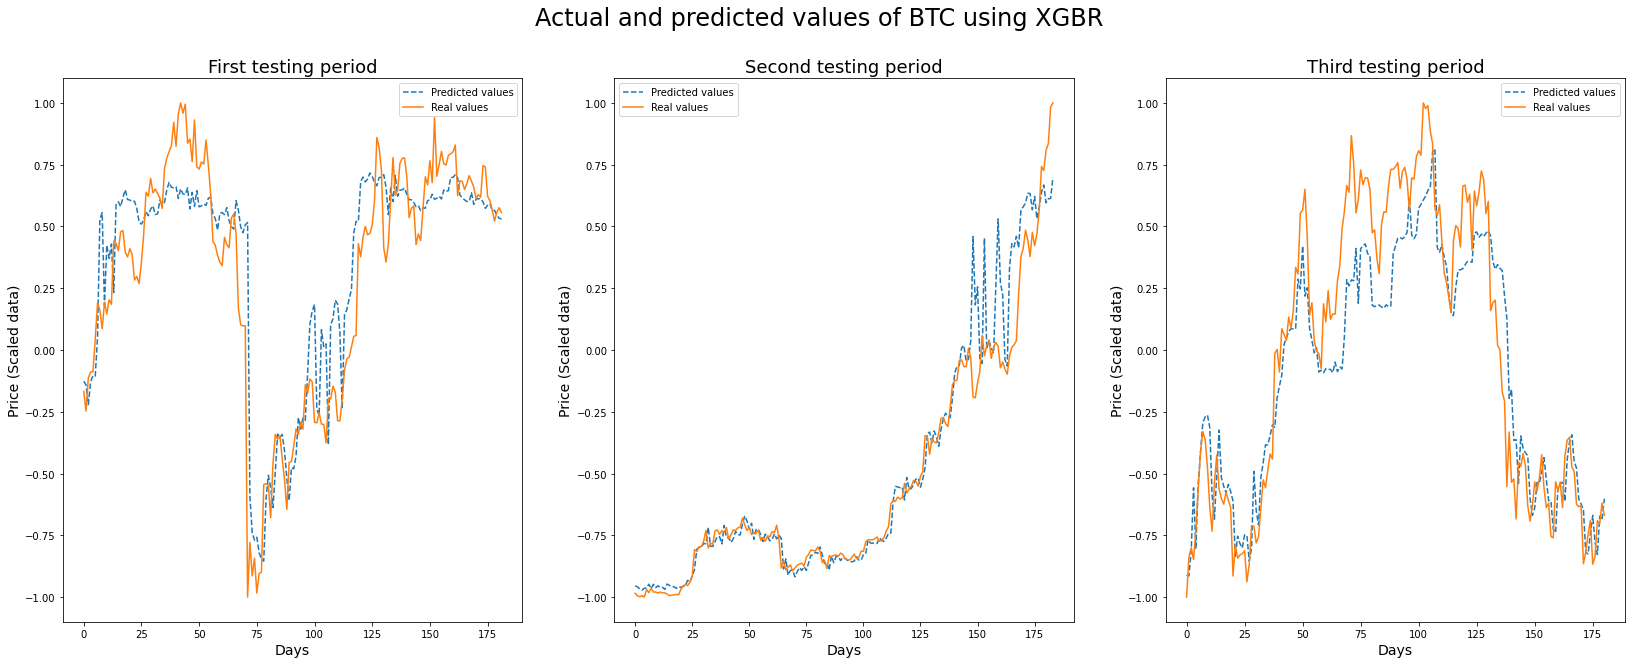

In [ ]:
Show.plot_three("Actual and predicted values of BTC using XGBR", predicted_values_XGBR_btc, real_values_XGBR_btc)

###### Parameters

In [ ]:
Show.show_params(models_XGBR_btc)

                     Parameters
-------------------  ---------------------------------------------------------------------------------------------------------------
Model first period   <bound method XGBModel.get_params of XGBRegressor(colsample_bytree=0.6, eta=0.4, eval_metric='rmse', gamma=0.0,
                                  max_depth=17, min_child_weight=5, n_estimators=500,
                                  objective='reg:squarederror')>
Model second period  <bound method XGBModel.get_params of XGBRegressor(colsample_bytree=0.8, eta=0.4, eval_metric='rmse', gamma=0.0,
                                  max_depth=8, min_child_weight=4, n_estimators=200,
                                  objective='reg:squarederror')>
Model thrid period   <bound method XGBModel.get_params of XGBRegressor(colsample_bytree=0.6, eta=0.4, eval_metric='rmse', gamma=0.0,
                                  max_depth=17, min_child_weight=5, n_estimators=500,
                                  objective='reg:

#### Multi-layer Perceptron Regressor (MLPR)

##### ETH

In [ ]:
models_MLPR_eth, predicted_values_MLPR_eth, real_values_MLPR_eth, mses_MLPR_eth, r2s_MLPR_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "MLPR")

###### Results

In [ ]:
Show.results_table(mses_MLPR_eth, r2s_MLPR_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.022562   0.88339
01/07/2020 - 31/12/2020  0.010876   0.947281
01/01/2021 - 30/06/2021  0.039155   0.817716
-----------------------  ---------  ---------
Average                  0.024198   0.882795


###### Graphs

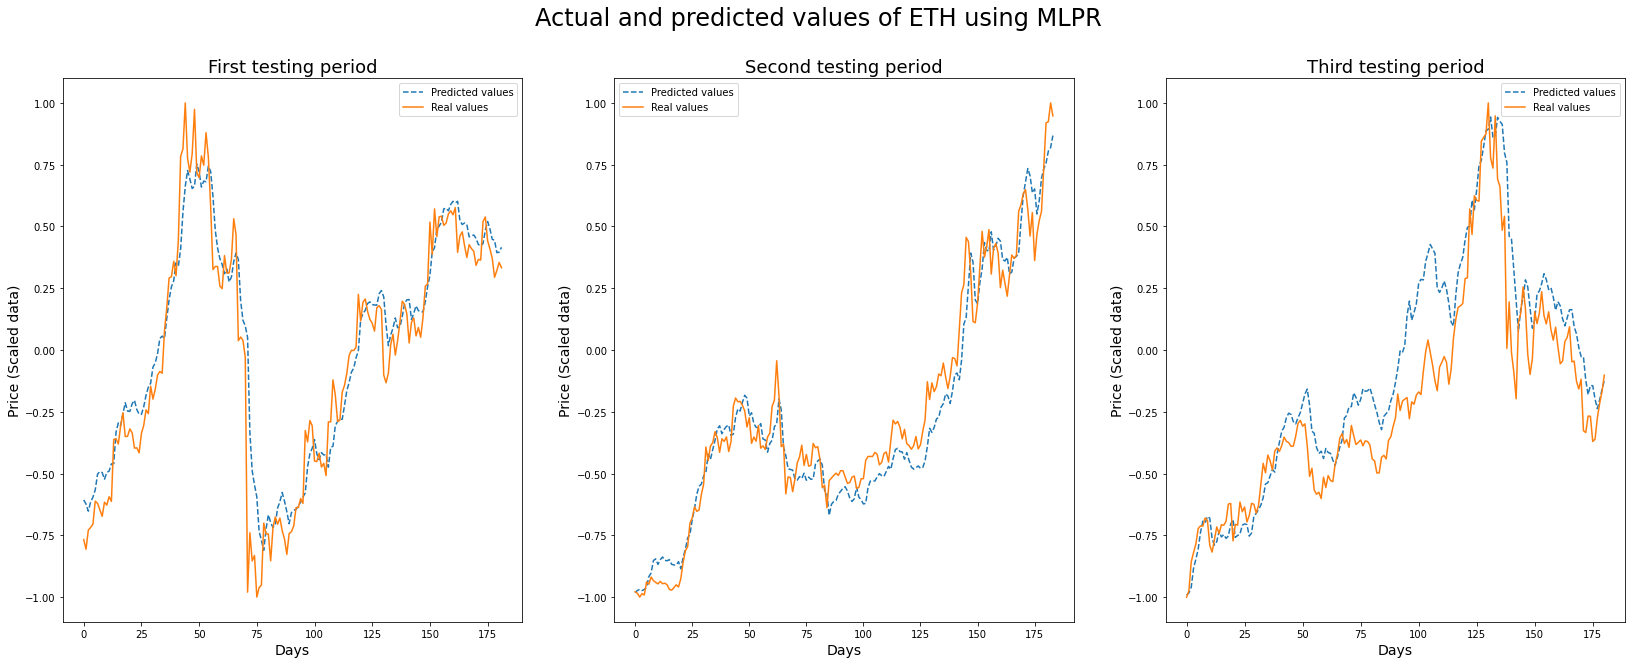

In [ ]:
Show.plot_three("Actual and predicted values of ETH using MLPR", predicted_values_MLPR_eth, real_values_MLPR_eth)

###### Parameters

In [ ]:
Show.show_params(models_MLPR_eth)

                     Parameters
-------------------  ----------------------------------------------------------------------------------------------------------------
Model first period   <bound method BaseEstimator.get_params of MLPRegressor(activation='logistic', alpha=0.1, hidden_layer_sizes=140,
                                  max_iter=500, momentum=0.95, random_state=89, verbose=0)>
Model second period  <bound method BaseEstimator.get_params of MLPRegressor(activation='logistic', alpha=0.1, hidden_layer_sizes=140,
                                  max_iter=500, momentum=0.95, random_state=89, verbose=0)>
Model thrid period   <bound method BaseEstimator.get_params of MLPRegressor(activation='logistic', alpha=0.1, hidden_layer_sizes=140,
                                  max_iter=500, momentum=0.95, random_state=89, verbose=0)>


##### BTC

In [ ]:
models_MLPR_btc, predicted_values_MLPR_btc, real_values_MLPR_btc, mses_MLPR_btc, r2s_MLPR_btc = training_pipeline(currency = "BTC", n_iterations = 100, ml_model = "MLPR")

###### Results

In [ ]:
Show.results_table(mses_MLPR_btc, r2s_MLPR_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.033399   0.839515
01/07/2020 - 31/12/2020  0.086046   0.244427
01/01/2021 - 30/06/2021  0.039572   0.823757
-----------------------  ---------  ---------
Average                  0.053006   0.635899


###### Graphs

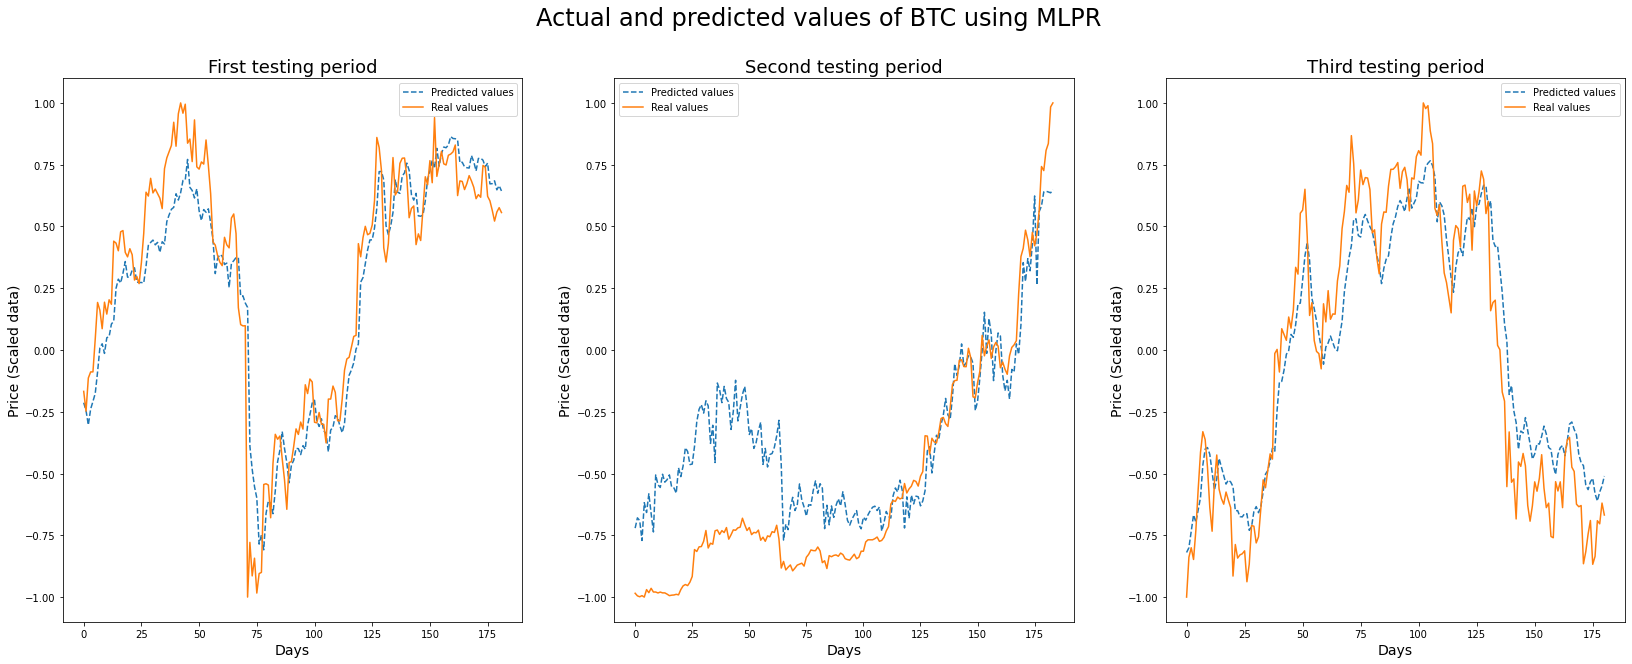

In [ ]:
Show.plot_three("Actual and predicted values of BTC using MLPR", predicted_values_MLPR_btc, real_values_MLPR_btc)

###### Parameters

In [ ]:
Show.show_params(models_MLPR_btc)

                     Parameters
-------------------  ------------------------------------------------------------------------------------------------------------
Model first period   <bound method BaseEstimator.get_params of MLPRegressor(activation='tanh', alpha=0.1, hidden_layer_sizes=130,
                                  learning_rate='adaptive', learning_rate_init=0.01, max_iter=500,
                                  random_state=56, verbose=0)>
Model second period  <bound method BaseEstimator.get_params of MLPRegressor(activation='tanh', alpha=0.1, hidden_layer_sizes=190,
                                  learning_rate='adaptive', learning_rate_init=0.0001, max_iter=500,
                                  random_state=73, verbose=0)>
Model thrid period   <bound method BaseEstimator.get_params of MLPRegressor(activation='tanh', alpha=0.1, hidden_layer_sizes=130,
                                  learning_rate='adaptive', learning_rate_init=0.01, max_iter=500,
                       

#### Lightgbm

##### ETH

In [ ]:
models_LGB_eth, predicted_values_LGB_eth, real_values_LGB_eth, mses_LGB_eth, r2s_LGB_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "LGB")

###### Results

In [ ]:
Show.results_table(mses_LGB_eth, r2s_LGB_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.028075   0.890497
01/07/2020 - 31/12/2020  0.019216   0.902953
01/01/2021 - 30/06/2021  0.008272   0.951234
-----------------------  ---------  ---------
Average                  0.018521   0.914895


###### Graphs

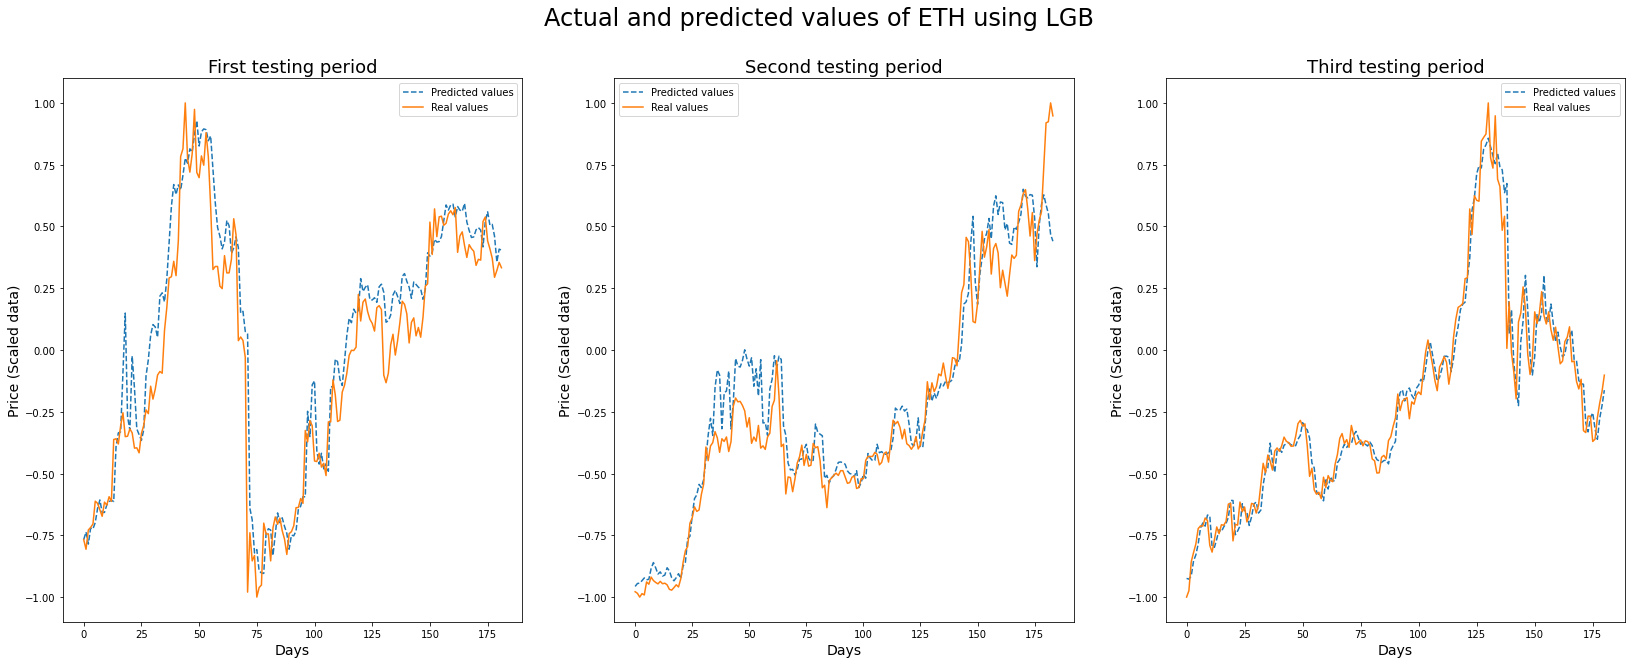

In [ ]:
Show.plot_three("Actual and predicted values of ETH using LGB", predicted_values_LGB_eth, real_values_LGB_eth)

###### Parameters

In [ ]:
Show.show_params(models_LGB_eth)

                     Parameters
-------------------  --------------------------------------------------------------------------------------------------------------------
Model first period   <bound method LGBMModel.get_params of LGBMRegressor(learning_rate=0.05, n_estimators=900, num_leaves=80, verbose=0)>
Model second period  <bound method LGBMModel.get_params of LGBMRegressor(n_estimators=800, num_leaves=20, verbose=0)>
Model thrid period   <bound method LGBMModel.get_params of LGBMRegressor(learning_rate=0.05, min_child_samples=10, n_estimators=200,
                                   num_leaves=20, verbose=0)>


##### BTC

In [ ]:
models_LGB_btc, predicted_values_LGB_btc, real_values_LGB_btc, mses_LGB_btc, r2s_LGB_btc = training_pipeline(currency = "BTC", n_iterations = 100, ml_model = "LGB")

###### Results

In [ ]:
Show.results_table(mses_LGB_btc, r2s_LGB_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.052902   0.662462
01/07/2020 - 31/12/2020  0.010795   0.953011
01/01/2021 - 30/06/2021  0.056746   0.79673
-----------------------  ---------  ---------
Average                  0.040148   0.804068


###### Graphs

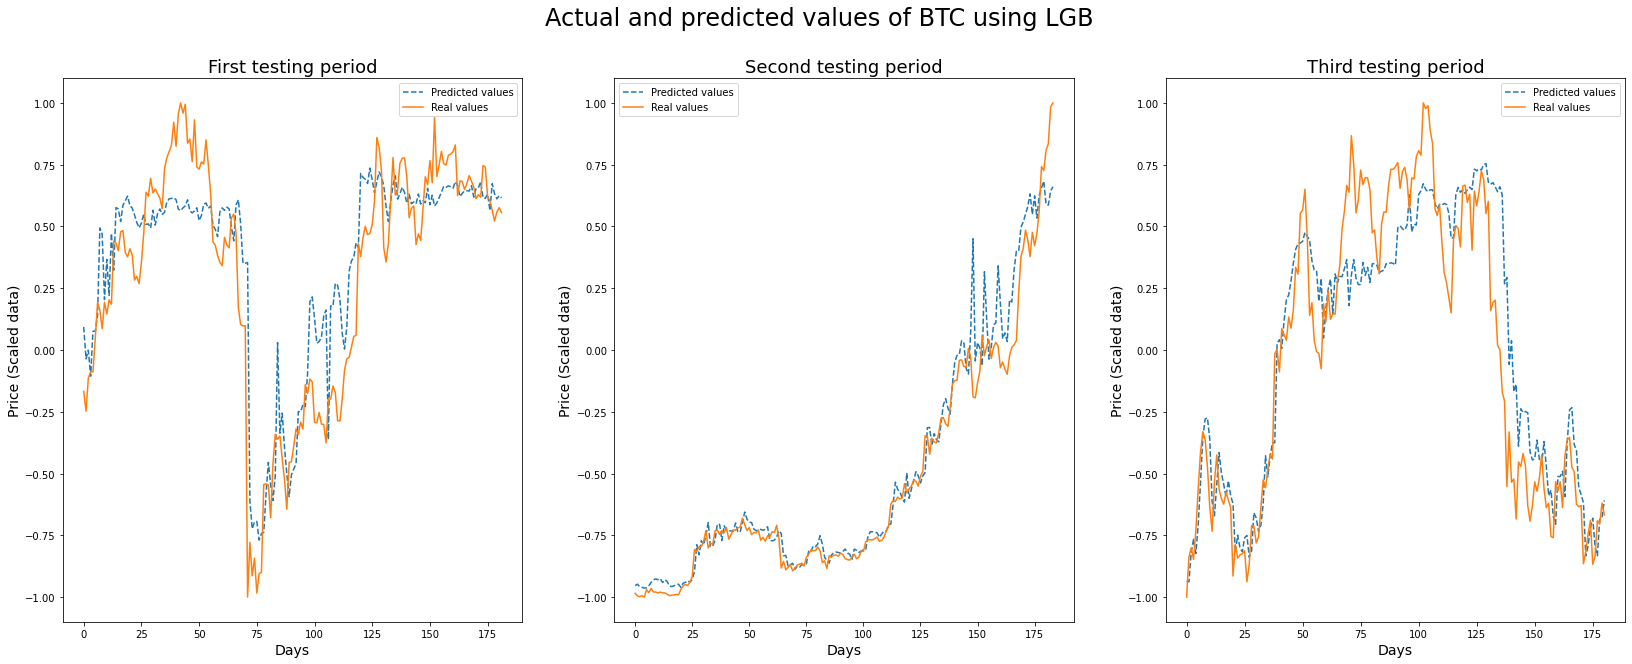

In [ ]:
Show.plot_three("Actual and predicted values of BTC using LGB", predicted_values_LGB_btc, real_values_LGB_btc)

###### Parameters

In [ ]:
Show.show_params(models_LGB_btc)

                     Parameters
-------------------  ----------------------------------------------------------------------------------------------------------------------
Model first period   <bound method LGBMModel.get_params of LGBMRegressor(min_child_samples=10, num_leaves=50, verbose=0)>
Model second period  <bound method LGBMModel.get_params of LGBMRegressor(learning_rate=0.05, min_child_samples=15, n_estimators=200,
                                   num_leaves=60, verbose=0)>
Model thrid period   <bound method LGBMModel.get_params of LGBMRegressor(min_child_samples=10, n_estimators=900, num_leaves=60, verbose=0)>


#### Cat

##### ETH

In [ ]:
models_CAT_eth, predicted_values_CAT_eth, real_values_CAT_eth, mses_CAT_eth, r2s_CAT_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "CAT")

###### Results

In [ ]:
Show.results_table(mses_CAT_eth, r2s_CAT_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.032937   0.860081
01/07/2020 - 31/12/2020  0.020056   0.881046
01/01/2021 - 30/06/2021  0.012241   0.9248
-----------------------  ---------  ---------
Average                  0.021745   0.888643


###### Graphs

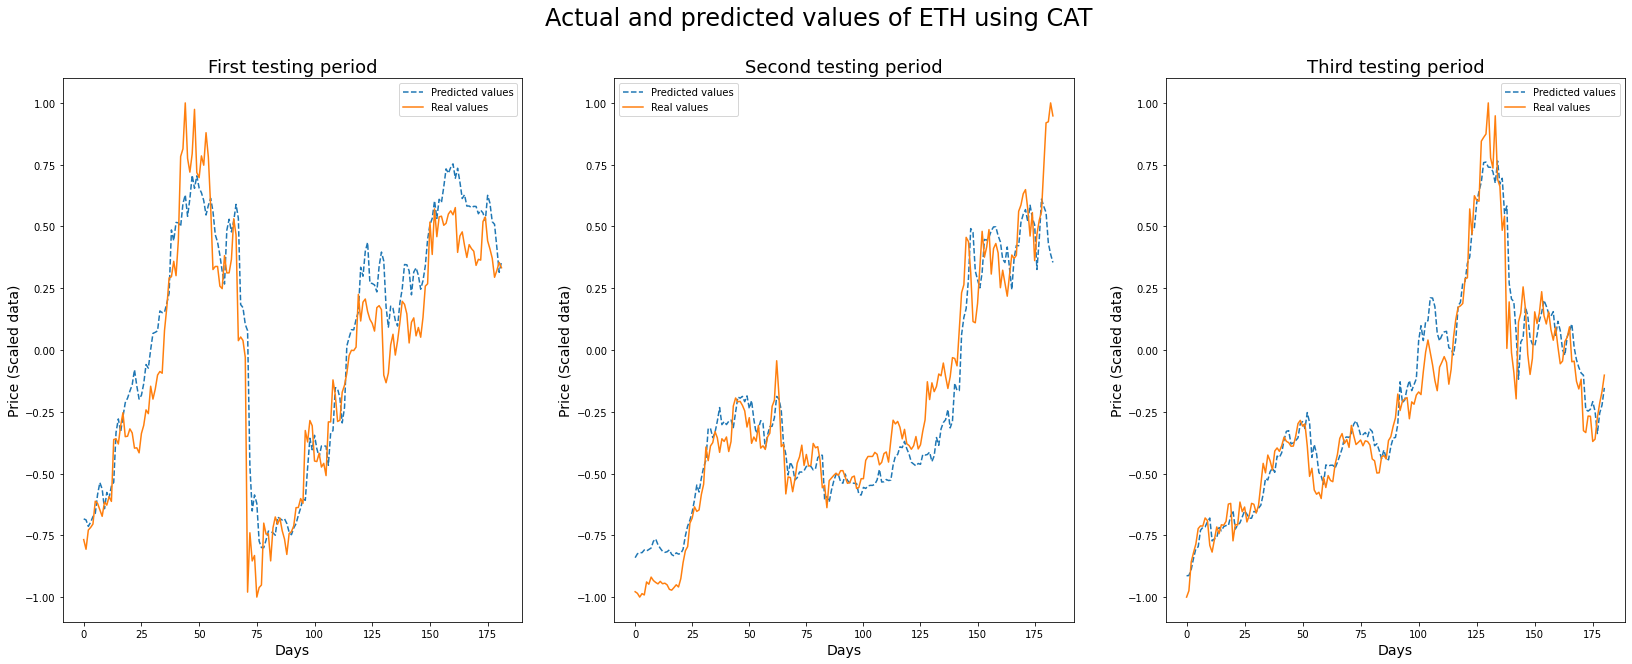

In [ ]:
Show.plot_three("Actual and predicted values of ETH using CAT", predicted_values_CAT_eth, real_values_CAT_eth)

###### Parameters

In [ ]:
Show.show_params(models_CAT_eth)

                     Parameters
-------------------  ------------------------------------------------------------------------------------------------
Model first period   <bound method CatBoost.get_params of <catboost.core.CatBoostRegressor object at 0x7f0b6f1f7450>>
Model second period  <bound method CatBoost.get_params of <catboost.core.CatBoostRegressor object at 0x7f0b6c6036d0>>
Model thrid period   <bound method CatBoost.get_params of <catboost.core.CatBoostRegressor object at 0x7f0b6c5ade90>>


##### BTC

In [ ]:
models_CAT_btc, predicted_values_CAT_btc, real_values_CAT_btc, mses_CAT_btc, r2s_CAT_btc = training_pipeline(currency = "BTC", n_iterations = 500, ml_model = "CAT")

###### Results

In [ ]:
Show.results_table(mses_CAT_btc, r2s_CAT_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.037527   0.752179
01/07/2020 - 31/12/2020  0.027449   0.845659
01/01/2021 - 30/06/2021  0.081612   0.560809
-----------------------  ---------  ---------
Average                  0.048862   0.719549


###### Graphs

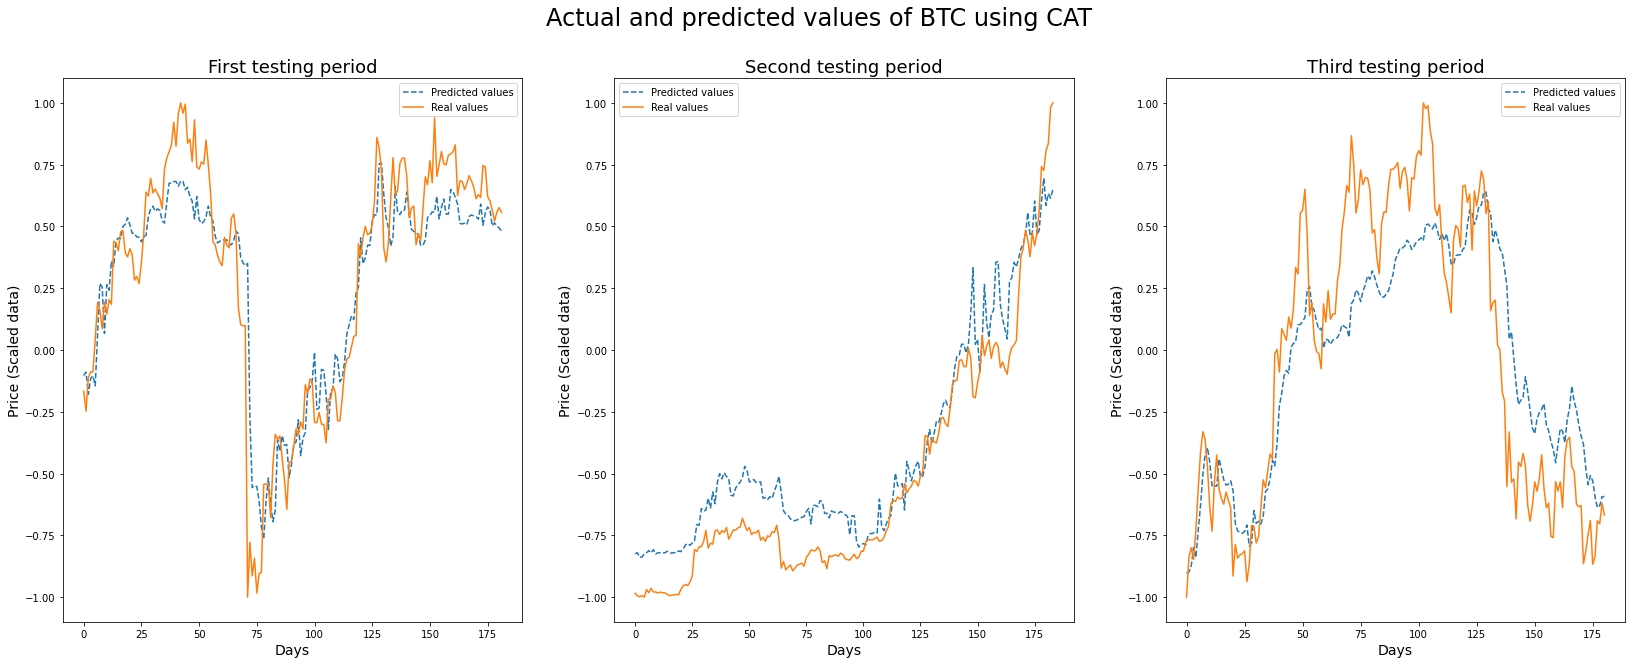

In [ ]:
Show.plot_three("Actual and predicted values of BTC using CAT", predicted_values_CAT_btc, real_values_CAT_btc)

###### Parameters

In [ ]:
Show.show_params(models_CAT_btc)

                     Parameters
-------------------  ------------------------------------------------------------------------------------------------
Model first period   <bound method CatBoost.get_params of <catboost.core.CatBoostRegressor object at 0x7f9db992c1d0>>
Model second period  <bound method CatBoost.get_params of <catboost.core.CatBoostRegressor object at 0x7f9db974c090>>
Model thrid period   <bound method CatBoost.get_params of <catboost.core.CatBoostRegressor object at 0x7f9db9912550>>


### **Deep learning**

#### LSTM Simple

##### ETH

In [ ]:
RNeuro = NNAlgorithms() #Reset
warnings.filterwarnings("ignore", category=DeprecationWarning)
models_LSTM_eth, predicted_values_LSTM_eth, real_values_LSTM_eth, mses_LSTM_eth, r2s_LSTM_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "lstm_simple")

###### Results

In [ ]:
mses_LSTM_eth = [RNeuro.lowest_error['first_set'], RNeuro.lowest_error['second_set'], RNeuro.lowest_error['thrid_set']]
r2s_LSTM_eth = [RNeuro.r2s['first_set'],RNeuro.r2s['second_set'],RNeuro.r2s['thrid_set']]
Show.results_table(mses_LSTM_eth, r2s_LSTM_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.04303    0.817936
01/07/2020 - 31/12/2020  0.034054   0.837282
01/01/2021 - 30/06/2021  0.048363   0.703365
-----------------------  ---------  ---------
Average                  0.041816   0.786194


###### Graphs

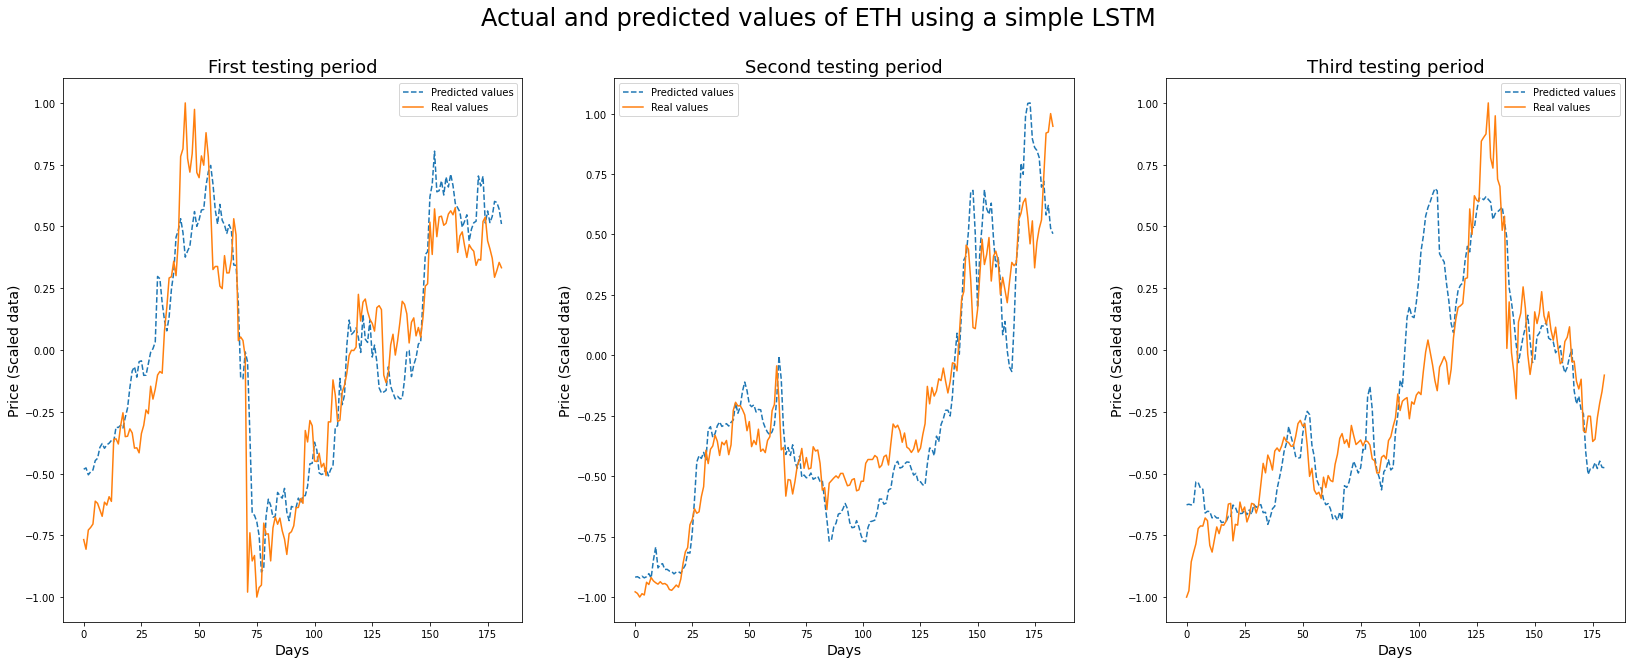

In [ ]:
predicted_values_LSTM_eth = [RNeuro.predicted_values['first_set'], RNeuro.predicted_values['second_set'], RNeuro.predicted_values['thrid_set']]
real_values_LSTM_eth = [RNeuro.real_values['first_set'], RNeuro.real_values['second_set'], RNeuro.real_values['thrid_set']]

Show.plot_three("Actual and predicted values of ETH using a simple LSTM", predicted_values_LSTM_eth, real_values_LSTM_eth)

###### Parameters

In [ ]:
print(RNeuro.best_model['first_set'].summary())
print(RNeuro.best_model['second_set'].summary())
print(RNeuro.best_model['thrid_set'].summary())

Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_113 (LSTM)             (None, 160)               103680    
                                                                 
 dense_113 (Dense)           (None, 1)                 161       
                                                                 
Total params: 103,841
Trainable params: 103,841
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_135 (LSTM)             (None, 215)               186620    
                                                                 
 dense_135 (Dense)           (None, 1)                 216       
                                                                 
Total params: 186

##### BTC

In [ ]:
RNeuro = NNAlgorithms() #Reset
warnings.filterwarnings("ignore", category=DeprecationWarning)
models_LSTM_btc, predicted_values_LSTM_btc, real_values_LSTM_btc, mses_LSTM_btc, r2s_LSTM_btc = training_pipeline(currency = "BTC", n_iterations = 100, ml_model = "lstm_simple")

###### Results

In [ ]:
mses_LSTM_btc = [RNeuro.lowest_error['first_set'], RNeuro.lowest_error['second_set'], RNeuro.lowest_error['thrid_set']]
r2s_LSTM_btc = [RNeuro.r2s['first_set'],RNeuro.r2s['second_set'],RNeuro.r2s['thrid_set']]

Show.results_table(mses_LSTM_btc, r2s_LSTM_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.045041   0.808051
01/07/2020 - 31/12/2020  0.010523   0.950966
01/01/2021 - 30/06/2021  0.129956   0.621239
-----------------------  ---------  ---------
Average                  0.06184    0.793419


###### Graphs

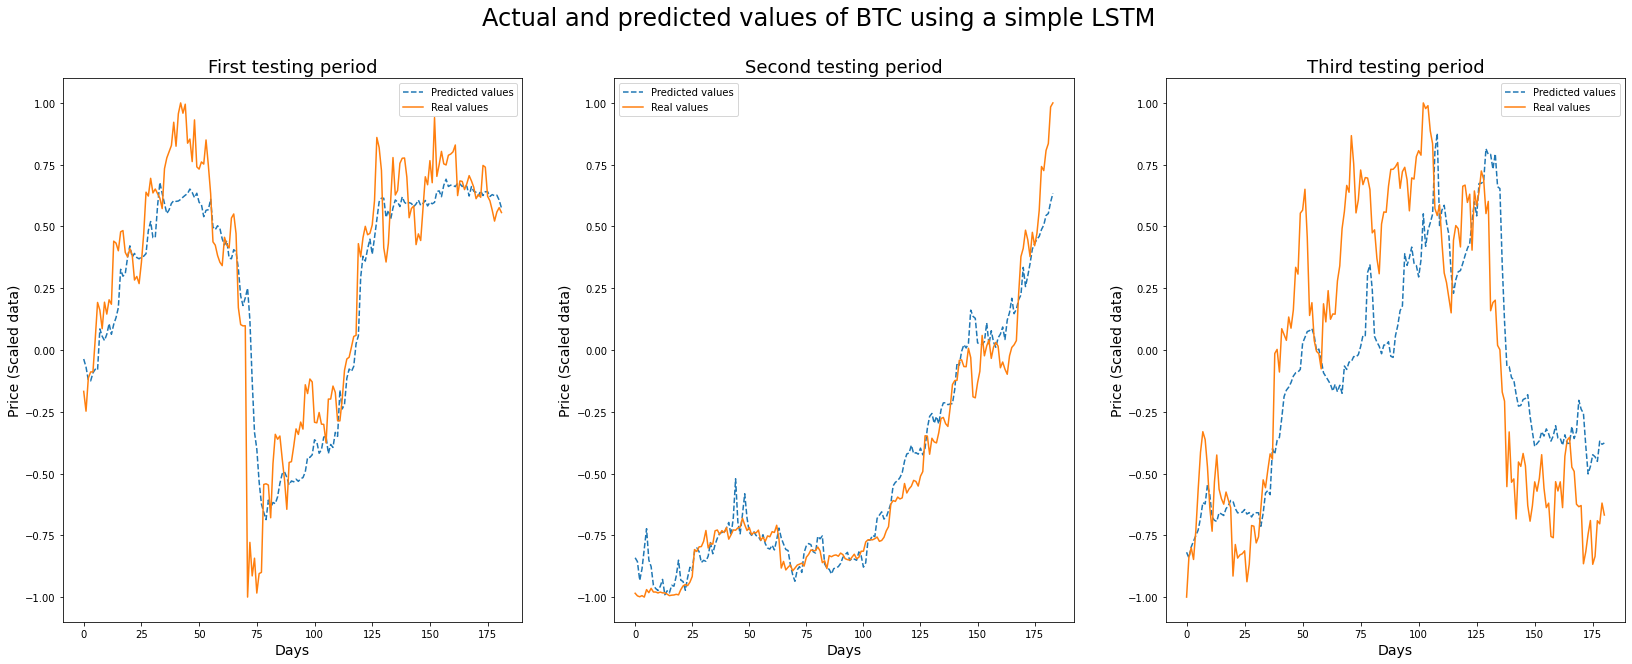

In [ ]:
predicted_values_LSTM_btc = [RNeuro.predicted_values['first_set'], RNeuro.predicted_values['second_set'], RNeuro.predicted_values['thrid_set']]
real_values_LSTM_btc = [RNeuro.real_values['first_set'], RNeuro.real_values['second_set'], RNeuro.real_values['thrid_set']]

Show.plot_three("Actual and predicted values of BTC using a simple LSTM", predicted_values_LSTM_btc, real_values_LSTM_btc)

###### Parameters

In [ ]:
print(RNeuro.best_model['first_set'].summary())
print(RNeuro.best_model['second_set'].summary())
print(RNeuro.best_model['thrid_set'].summary())

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_79 (LSTM)              (None, 65)                17420     
                                                                 
 dense_79 (Dense)            (None, 1)                 66        
                                                                 
Total params: 17,486
Trainable params: 17,486
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_106 (LSTM)             (None, 45)                8460      
                                                                 
 dense_106 (Dense)           (None, 1)                 46        
                                                                 
Total params: 8,506


#### LSTM Stacked

##### ETH

In [ ]:
RNeuro = NNAlgorithms() #Reset
warnings.filterwarnings("ignore", category=DeprecationWarning)
models_LSTM_stacked_eth, predicted_values_LSTM_stacked_eth, real_values_LSTM_stacked_eth, mses_LSTM_stacked_eth, r2s_LSTM_stacked_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "lstm_stack")

###### Results

In [ ]:
mses_LSTM_stacked_eth = [RNeuro.lowest_error['first_set'], RNeuro.lowest_error['second_set'], RNeuro.lowest_error['thrid_set']]
r2s_LSTM_stacked_eth = [RNeuro.r2s['first_set'],RNeuro.r2s['second_set'],RNeuro.r2s['thrid_set']]
Show.results_table(mses_LSTM_stacked_eth, r2s_LSTM_stacked_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.07169    0.696673
01/07/2020 - 31/12/2020  0.043402   0.792614
01/01/2021 - 30/06/2021  0.099508   0.38967
-----------------------  ---------  ---------
Average                  0.071533   0.626319


###### Graphs

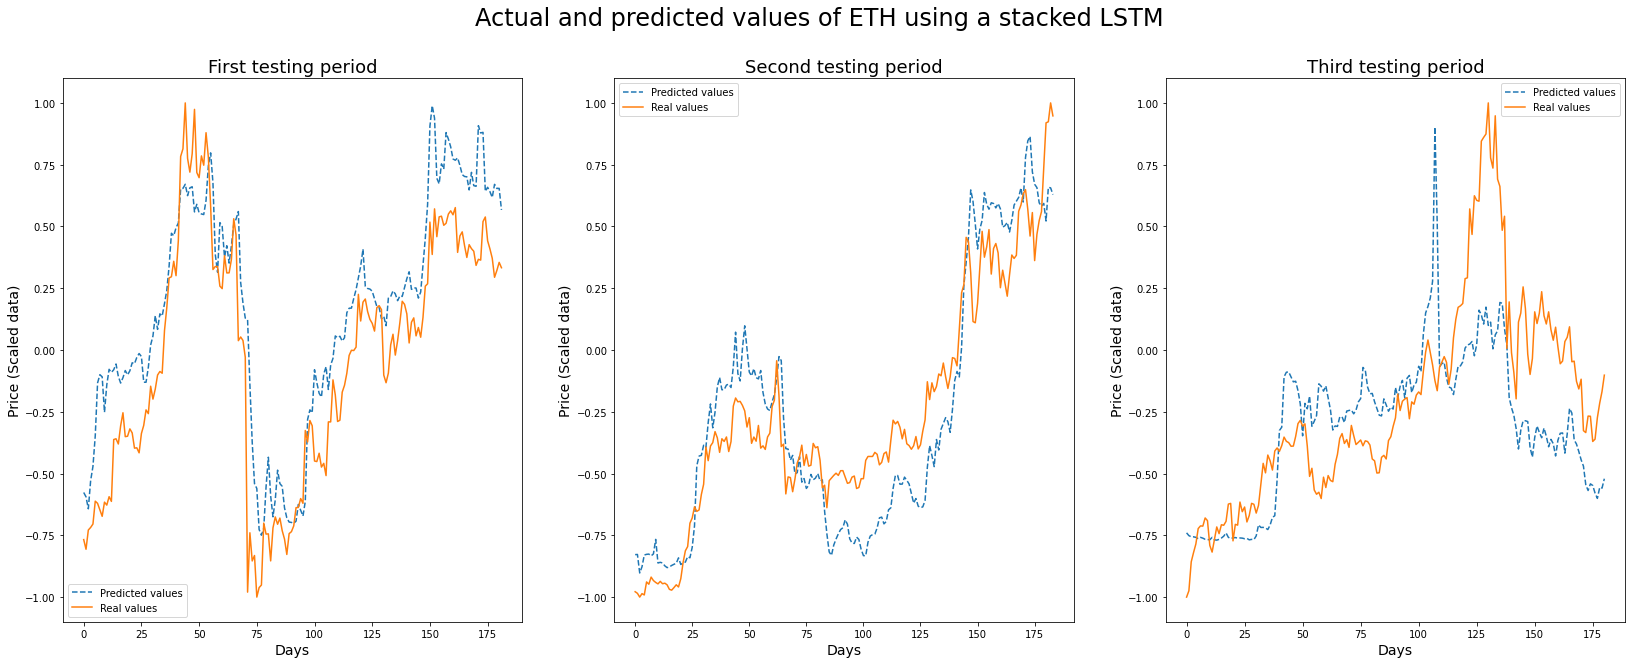

In [ ]:
predicted_values_LSTM_stacked_eth = [RNeuro.predicted_values['first_set'], RNeuro.predicted_values['second_set'], RNeuro.predicted_values['thrid_set']]
real_values_LSTM_stacked_eth = [RNeuro.real_values['first_set'], RNeuro.real_values['second_set'], RNeuro.real_values['thrid_set']]

Show.plot_three("Actual and predicted values of ETH using a stacked LSTM", predicted_values_LSTM_stacked_eth, real_values_LSTM_stacked_eth)

###### Parameters

In [ ]:
print(RNeuro.best_model['first_set'].summary())
print(RNeuro.best_model['second_set'].summary())
print(RNeuro.best_model['thrid_set'].summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 122, 130)          68640     
                                                                 
 dropout_21 (Dropout)        (None, 122, 130)          0         
                                                                 
 lstm_26 (LSTM)              (None, 122, 180)          223920    
                                                                 
 dropout_22 (Dropout)        (None, 122, 180)          0         
                                                                 
 lstm_27 (LSTM)              (None, 45)                40680     
                                                                 
 dropout_23 (Dropout)        (None, 45)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

##### BTC

In [ ]:
RNeuro = NNAlgorithms() #Reset
warnings.filterwarnings("ignore", category=DeprecationWarning)
models_LSTM_stacked_btc, predicted_values_LSTM_stacked_btc, real_values_LSTM_stacked_btc, mses_LSTM_stacked_btc, r2s_LSTM_stacked_btc = training_pipeline(currency = "BTC", n_iterations = 100, ml_model = "lstm_stack")

###### Results

In [ ]:
mses_LSTM_stacked_btc = [RNeuro.lowest_error['first_set'], RNeuro.lowest_error['second_set'], RNeuro.lowest_error['thrid_set']]
r2s_LSTM_stacked_btc = [RNeuro.r2s['first_set'],RNeuro.r2s['second_set'],RNeuro.r2s['thrid_set']]

Show.results_table(mses_LSTM_stacked_btc, r2s_LSTM_stacked_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.061454   0.738108
01/07/2020 - 31/12/2020  0.014348   0.933147
01/01/2021 - 30/06/2021  0.086535   0.747791
-----------------------  ---------  ---------
Average                  0.054112   0.806348


###### Graphs

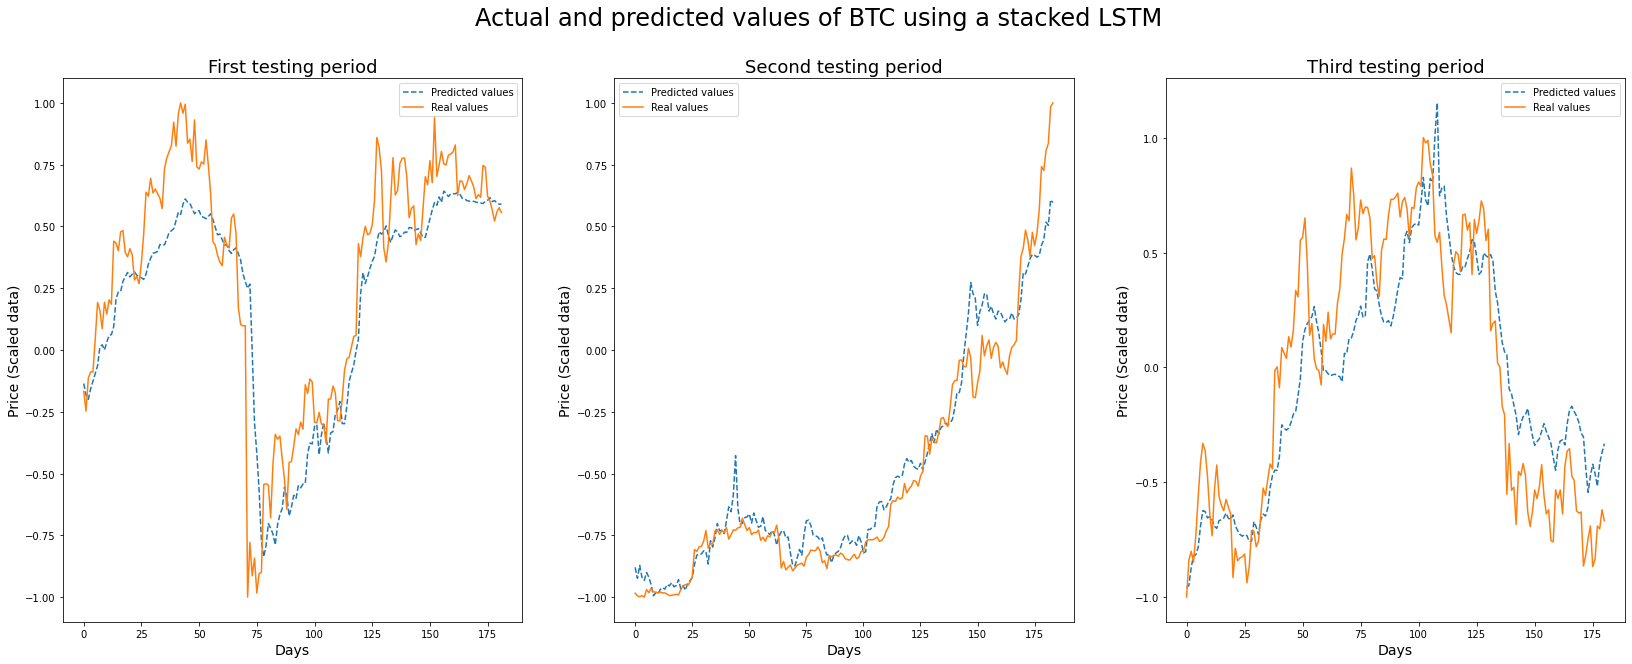

In [ ]:
predicted_values_LSTM_stacked_btc = [RNeuro.predicted_values['first_set'], RNeuro.predicted_values['second_set'], RNeuro.predicted_values['thrid_set']]
real_values_LSTM_stacked_btc = [RNeuro.real_values['first_set'], RNeuro.real_values['second_set'], RNeuro.real_values['thrid_set']]

Show.plot_three("Actual and predicted values of BTC using a stacked LSTM", predicted_values_LSTM_stacked_btc, real_values_LSTM_stacked_btc)

###### Parameters

In [ ]:
print(RNeuro.best_model['first_set'].summary())
print(RNeuro.best_model['second_set'].summary())
print(RNeuro.best_model['thrid_set'].summary())

Model: "sequential_400"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1192 (LSTM)            (None, 122, 185)          138380    
                                                                 
 dropout_1188 (Dropout)      (None, 122, 185)          0         
                                                                 
 lstm_1193 (LSTM)            (None, 122, 110)          130240    
                                                                 
 dropout_1189 (Dropout)      (None, 122, 110)          0         
                                                                 
 lstm_1194 (LSTM)            (None, 85)                66640     
                                                                 
 dropout_1190 (Dropout)      (None, 85)                0         
                                                                 
 dense_400 (Dense)           (None, 1)              

#### Bidirectional LSTM

##### ETH

In [ ]:
RNeuro = NNAlgorithms() #Reset
warnings.filterwarnings("ignore", category=DeprecationWarning)
models_LSTM_bi_eth, predicted_values_LSTM_bi_eth, real_values_LSTM_bi_eth, mses_LSTM_bi_eth, r2s_LSTM_bi_eth = training_pipeline(currency = "ETH", n_iterations = 100, ml_model = "lstm_bi")

###### Results

In [ ]:
mses_LSTM_bi_eth = [RNeuro.lowest_error['first_set'], RNeuro.lowest_error['second_set'], RNeuro.lowest_error['thrid_set']]
r2s_LSTM_bi_eth = [RNeuro.r2s['first_set'],RNeuro.r2s['second_set'],RNeuro.r2s['thrid_set']]
Show.results_table(mses_LSTM_bi_eth, r2s_LSTM_bi_eth)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.023358   0.90117
01/07/2020 - 31/12/2020  0.011756   0.943828
01/01/2021 - 30/06/2021  0.011873   0.927176
-----------------------  ---------  ---------
Average                  0.015662   0.924058


###### Graphs

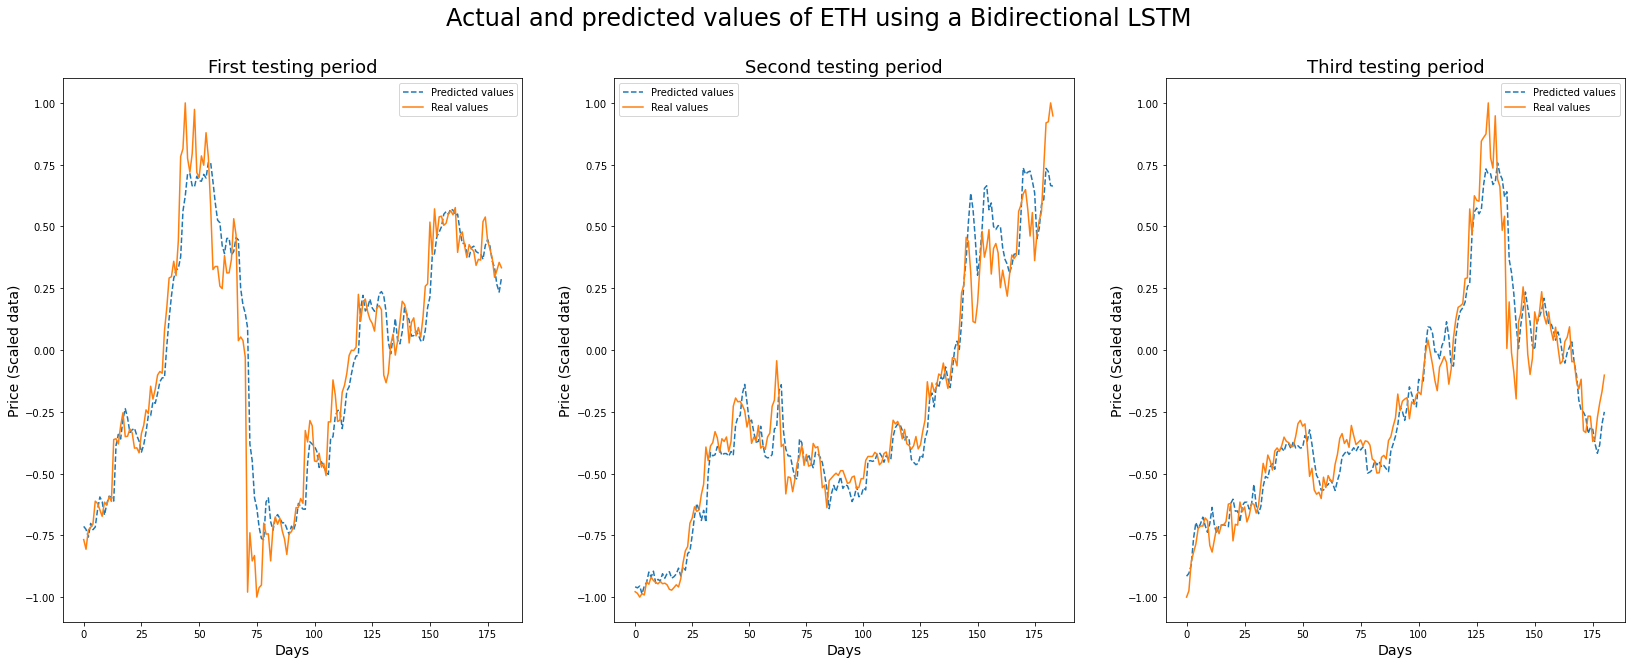

In [ ]:
predicted_values_LSTM_bi_eth = [RNeuro.predicted_values['first_set'], RNeuro.predicted_values['second_set'], RNeuro.predicted_values['thrid_set']]
real_values_LSTM_bi_eth = [RNeuro.real_values['first_set'], RNeuro.real_values['second_set'], RNeuro.real_values['thrid_set']]

Show.plot_three("Actual and predicted values of ETH using a Bidirectional LSTM", predicted_values_LSTM_bi_eth, real_values_LSTM_bi_eth)

###### Parameters

In [ ]:
print(RNeuro.best_model['first_set'].summary())
print(RNeuro.best_model['second_set'].summary())
print(RNeuro.best_model['thrid_set'].summary())

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_51 (Bidirecti  (None, 410)              339480    
 onal)                                                           
                                                                 
 dense_51 (Dense)            (None, 1)                 411       
                                                                 
Total params: 339,891
Trainable params: 339,891
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_194"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_194 (Bidirect  (None, 370)              276760    
 ional)                                                          
                                                                 
 dense_194 (Dense)

##### BTC

In [ ]:
RNeuro = NNAlgorithms() #Reset
warnings.filterwarnings("ignore", category=DeprecationWarning)
models_LSTM_bi_btc, predicted_values_LSTM_bi_btc, real_values_LSTM_bi_btc, mses_LSTM_bi_btc, r2s_LSTM_bi_btc = training_pipeline(currency = "BTC", n_iterations = 100, ml_model = "lstm_bi")

###### Results

In [ ]:
mses_LSTM_bi_btc = [RNeuro.lowest_error['first_set'], RNeuro.lowest_error['second_set'], RNeuro.lowest_error['thrid_set']]
r2s_LSTM_bi_btc = [RNeuro.r2s['first_set'],RNeuro.r2s['second_set'],RNeuro.r2s['thrid_set']]

Show.results_table(mses_LSTM_bi_btc, r2s_LSTM_bi_btc)

Testing period           MSE        R2
-----------------------  ---------  ---------
31/12/2019 - 30/06/2020  0.080382   0.657442
01/07/2020 - 31/12/2020  0.019465   0.909302
01/01/2021 - 30/06/2021  0.244418   0.287636
-----------------------  ---------  ---------
Average                  0.114755   0.618127


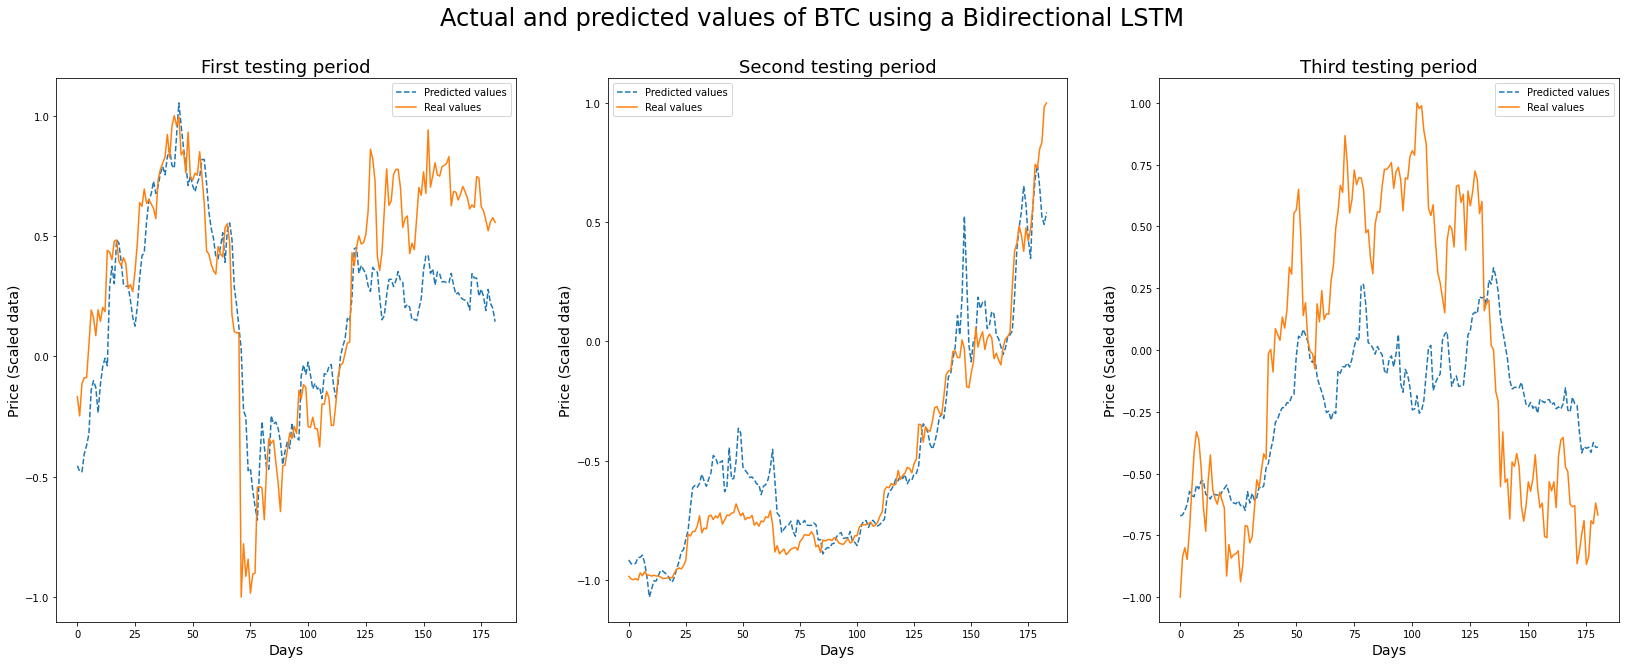

In [ ]:
predicted_values_LSTM_bi_btc = [RNeuro.predicted_values['first_set'], RNeuro.predicted_values['second_set'], RNeuro.predicted_values['thrid_set']]
real_values_LSTM_bi_btc = [RNeuro.real_values['first_set'], RNeuro.real_values['second_set'], RNeuro.real_values['thrid_set']]

Show.plot_three("Actual and predicted values of BTC using a Bidirectional LSTM", predicted_values_LSTM_bi_btc, real_values_LSTM_bi_btc)

###### Parameters

In [ ]:
print(RNeuro.best_model['first_set'].summary())
print(RNeuro.best_model['second_set'].summary())
print(RNeuro.best_model['thrid_set'].summary())

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_80 (Bidirecti  (None, 410)              339480    
 onal)                                                           
                                                                 
 dense_80 (Dense)            (None, 1)                 411       
                                                                 
Total params: 339,891
Trainable params: 339,891
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_160 (Bidirect  (None, 390)              307320    
 ional)                                                          
                                                                 
 dense_160 (Dense)